## Bike Rental Prediction with ANN: Learning Rate = 1e-4

This project aims at predicting bike rental rate based on weather and holiday information. The dataset contains hourly count of public bikes rented in Seoul Bike Sharing System, along with the corresponding weather data and holidays information, and is available at: https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

In this notebook, we train an artificial neural network with learning rate = 1e-4 to make predictions

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# reading feature-engineered saved data file
df = pd.read_pickle('data_feat_eng.pkl')

In [3]:
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,Year,No Holiday,Funct_Day
0,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,12,0,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,12,0,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,12,0,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,12,0,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,12,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   int64  
 8   Rainfall(mm)               8760 non-null   int64  
 9   Snowfall (cm)              8760 non-null   int64  
 10  Month                      8760 non-null   int64  
 11  Year                       8760 non-null   int64  
 12  No Holiday                 8760 non-null   uint8  
 13  Funct_Day                  8760 non-null   uint8

There are 13 numerical features

### Train-Test Splitting of Data

In [5]:
# features and labels are singled out of the dataframe

X = df.drop(['Rented Bike Count'],axis=1)
y = df['Rented Bike Count']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Data pre-processing

Pairwise correlation of features, if high, may suggest throwing away some of the features

Text(0.5, 1.0, 'Pairwise Correlation of Featues')

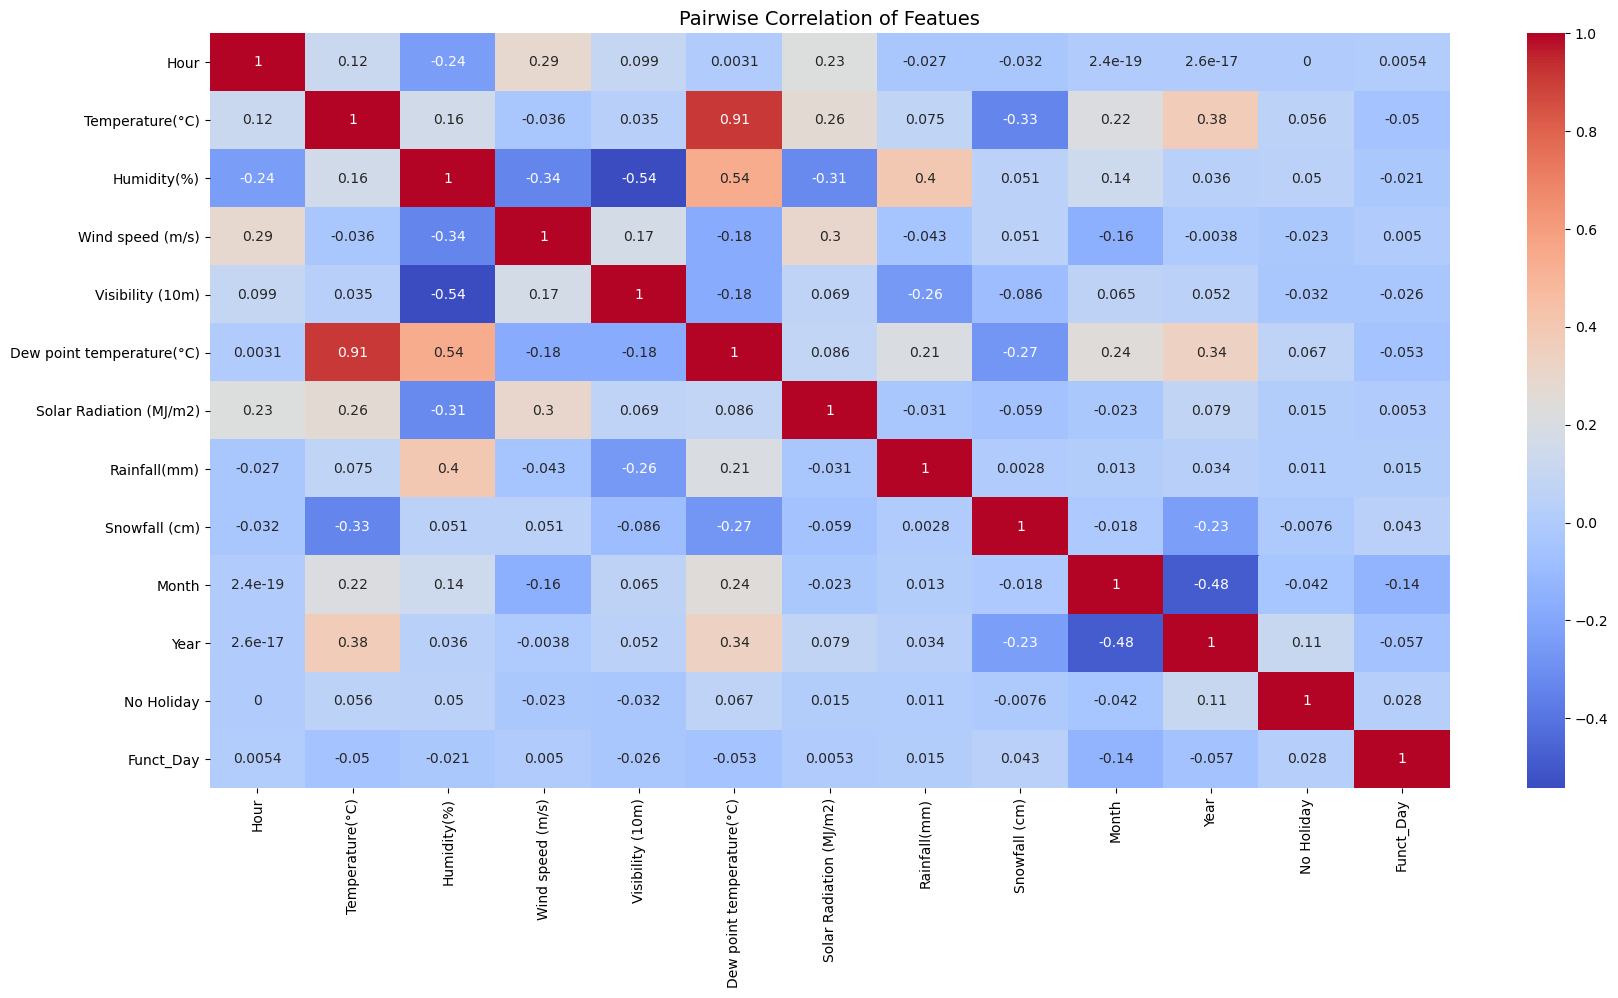

In [6]:
# pairwise correlation of featues
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(X.corr(),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation of Featues', fontsize=14)

There is a single highly correlated pair. We may need to perform PCA

#### Principal Component Analysis

In [7]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

To see how many principal components may be needed, let us plot cumulative explained variance

Text(0, 0.5, 'Cumulative explained variance')

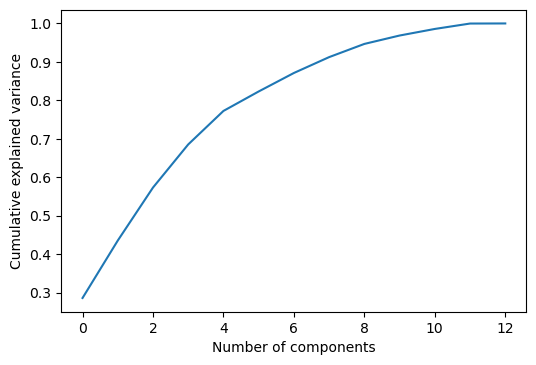

In [8]:
from sklearn.decomposition import PCA

# making the list of cumulative explained variance
pca = PCA().fit(X_train)
cumsum_list = pca.explained_variance_ratio_.cumsum()

# making the plot of cumulative explained variance
plt.figure(dpi=100)
plt.plot(cumsum_list)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

We will retain as many principal components as account for 99% cumulative variance:

In [9]:
pc_model = PCA(n_components=0.99, svd_solver='full')
pc_model.fit(X_train)
pc_model.n_components_ 

12

This rids of one more feature. Now we select out the proncipal components

In [10]:
# principal component selection
X_train = pc_model.fit_transform(X_train)
X_test = pc_model.transform(X_test)

Next we create an artificial neural network for training

### Creating the Model

In [11]:
# import tensorflow and check version
import tensorflow as tf
tf.__version__

'2.4.1'

In [12]:
# imports for network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [13]:
def create_ann():
    '''This function creates an ANN model'''
    
    # start neural network
    model = Sequential()
    
    model.add(Dense(12, activation='relu')) # input layer
    
    model.add(Dense(12, activation='relu')) # first hidden layer
    
    model.add(Dense(12, activation='relu')) # second hidden layer
    
    model.add(Dense(1))                    # output layer
    
    # compile neural network
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) # default learning_rate = 0.001
    model.compile(optimizer=opt,loss='mae')
    
    # return compiled network
    return model

In [14]:
# model created
ann = create_ann()

In [15]:
import time
t1 = time.time()

# training the model
ann.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=128, epochs=10_000)

t2 = time.time()

Epoch 1/10000
50/50 [==============================] - 3s 43ms/step - loss: 709.0612 - val_loss: 697.9971
Epoch 2/10000
50/50 [==============================] - 0s 2ms/step - loss: 715.4386 - val_loss: 697.9537
Epoch 3/10000
50/50 [==============================] - 0s 3ms/step - loss: 699.8788 - val_loss: 697.9023
Epoch 4/10000
50/50 [==============================] - 0s 3ms/step - loss: 692.4285 - val_loss: 697.8415
Epoch 5/10000
50/50 [==============================] - 0s 2ms/step - loss: 691.6324 - val_loss: 697.7689
Epoch 6/10000
50/50 [==============================] - 0s 3ms/step - loss: 706.9573 - val_loss: 697.6808
Epoch 7/10000
50/50 [==============================] - 0s 3ms/step - loss: 711.4396 - val_loss: 697.5743
Epoch 8/10000
50/50 [==============================] - 0s 3ms/step - loss: 712.7752 - val_loss: 697.4451
Epoch 9/10000
50/50 [==============================] - 0s 3ms/step - loss: 703.1755 - val_loss: 697.2887
Epoch 10/10000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 472.8723 - val_loss: 462.9807
Epoch 79/10000
50/50 [==============================] - 0s 3ms/step - loss: 460.5233 - val_loss: 457.1392
Epoch 80/10000
50/50 [==============================] - 0s 3ms/step - loss: 458.1171 - val_loss: 451.3922
Epoch 81/10000
50/50 [==============================] - 0s 3ms/step - loss: 464.4001 - val_loss: 445.7248
Epoch 82/10000
50/50 [==============================] - 0s 3ms/step - loss: 463.6008 - val_loss: 440.1445
Epoch 83/10000
50/50 [==============================] - 0s 3ms/step - loss: 446.9509 - val_loss: 434.7101
Epoch 84/10000
50/50 [==============================] - 0s 3ms/step - loss: 444.2089 - val_loss: 429.3853
Epoch 85/10000
50/50 [==============================] - 0s 2ms/step - loss: 438.0182 - val_loss: 424.1087
Epoch 86/10000
50/50 [==============================] - 0s 3ms/step - loss: 427.4866 - val_loss: 418.9684
Epoch 87/10000
50/50 [==============================] - 0s 2m

Epoch 155/10000
50/50 [==============================] - 0s 3ms/step - loss: 287.6627 - val_loss: 290.0249
Epoch 156/10000
50/50 [==============================] - 0s 3ms/step - loss: 284.7415 - val_loss: 289.3812
Epoch 157/10000
50/50 [==============================] - 0s 3ms/step - loss: 286.4508 - val_loss: 288.7993
Epoch 158/10000
50/50 [==============================] - 0s 3ms/step - loss: 279.6488 - val_loss: 288.2162
Epoch 159/10000
50/50 [==============================] - 0s 3ms/step - loss: 274.7019 - val_loss: 287.6576
Epoch 160/10000
50/50 [==============================] - 0s 3ms/step - loss: 288.4916 - val_loss: 287.1191
Epoch 161/10000
50/50 [==============================] - 0s 3ms/step - loss: 284.6158 - val_loss: 286.5958
Epoch 162/10000
50/50 [==============================] - 0s 3ms/step - loss: 274.8281 - val_loss: 286.0114
Epoch 163/10000
50/50 [==============================] - 0s 3ms/step - loss: 283.2349 - val_loss: 285.4854
Epoch 164/10000
50/50 [==============

50/50 [==============================] - 0s 3ms/step - loss: 265.6546 - val_loss: 266.5402
Epoch 232/10000
50/50 [==============================] - 0s 3ms/step - loss: 263.4887 - val_loss: 266.3796
Epoch 233/10000
50/50 [==============================] - 0s 3ms/step - loss: 265.8662 - val_loss: 266.2118
Epoch 234/10000
50/50 [==============================] - 0s 3ms/step - loss: 269.9070 - val_loss: 266.0401
Epoch 235/10000
50/50 [==============================] - 0s 3ms/step - loss: 259.3643 - val_loss: 265.8930
Epoch 236/10000
50/50 [==============================] - 0s 3ms/step - loss: 263.9896 - val_loss: 265.7402
Epoch 237/10000
50/50 [==============================] - 0s 3ms/step - loss: 262.5280 - val_loss: 265.5898
Epoch 238/10000
50/50 [==============================] - 0s 3ms/step - loss: 268.6954 - val_loss: 265.4574
Epoch 239/10000
50/50 [==============================] - 0s 3ms/step - loss: 266.3195 - val_loss: 265.3022
Epoch 240/10000
50/50 [==============================

50/50 [==============================] - 0s 4ms/step - loss: 260.0820 - val_loss: 257.2514
Epoch 308/10000
50/50 [==============================] - 0s 3ms/step - loss: 263.3658 - val_loss: 257.1554
Epoch 309/10000
50/50 [==============================] - 0s 4ms/step - loss: 260.9236 - val_loss: 257.0496
Epoch 310/10000
50/50 [==============================] - 0s 4ms/step - loss: 258.6194 - val_loss: 256.9614
Epoch 311/10000
50/50 [==============================] - 0s 4ms/step - loss: 253.0309 - val_loss: 256.8767
Epoch 312/10000
50/50 [==============================] - 0s 4ms/step - loss: 259.7592 - val_loss: 256.7767
Epoch 313/10000
50/50 [==============================] - 0s 4ms/step - loss: 252.4727 - val_loss: 256.6877
Epoch 314/10000
50/50 [==============================] - 0s 3ms/step - loss: 253.5506 - val_loss: 256.5915
Epoch 315/10000
50/50 [==============================] - 0s 3ms/step - loss: 258.7130 - val_loss: 256.4961
Epoch 316/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 251.2471 - val_loss: 251.6449
Epoch 384/10000
50/50 [==============================] - 0s 3ms/step - loss: 249.9200 - val_loss: 251.5787
Epoch 385/10000
50/50 [==============================] - 0s 3ms/step - loss: 251.6584 - val_loss: 251.5292
Epoch 386/10000
50/50 [==============================] - 0s 3ms/step - loss: 251.5571 - val_loss: 251.4609
Epoch 387/10000
50/50 [==============================] - 0s 4ms/step - loss: 248.5713 - val_loss: 251.4170
Epoch 388/10000
50/50 [==============================] - 0s 4ms/step - loss: 249.6306 - val_loss: 251.3657
Epoch 389/10000
50/50 [==============================] - 0s 4ms/step - loss: 247.2670 - val_loss: 251.3162
Epoch 390/10000
50/50 [==============================] - 0s 3ms/step - loss: 246.9858 - val_loss: 251.2654
Epoch 391/10000
50/50 [==============================] - 0s 3ms/step - loss: 244.1916 - val_loss: 251.2209
Epoch 392/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 245.5582 - val_loss: 247.4379
Epoch 460/10000
50/50 [==============================] - 0s 3ms/step - loss: 249.1814 - val_loss: 247.3773
Epoch 461/10000
50/50 [==============================] - 0s 3ms/step - loss: 244.7648 - val_loss: 247.3322
Epoch 462/10000
50/50 [==============================] - 0s 3ms/step - loss: 241.9448 - val_loss: 247.2806
Epoch 463/10000
50/50 [==============================] - 0s 3ms/step - loss: 249.3419 - val_loss: 247.2278
Epoch 464/10000
50/50 [==============================] - 0s 3ms/step - loss: 245.1364 - val_loss: 247.1759
Epoch 465/10000
50/50 [==============================] - 0s 3ms/step - loss: 244.4744 - val_loss: 247.1250
Epoch 466/10000
50/50 [==============================] - 0s 3ms/step - loss: 245.7612 - val_loss: 247.0843
Epoch 467/10000
50/50 [==============================] - 0s 3ms/step - loss: 241.7101 - val_loss: 247.0273
Epoch 468/10000
50/50 [==============================

50/50 [==============================] - 0s 4ms/step - loss: 246.9550 - val_loss: 243.4046
Epoch 536/10000
50/50 [==============================] - 0s 4ms/step - loss: 240.9979 - val_loss: 243.3242
Epoch 537/10000
50/50 [==============================] - 0s 4ms/step - loss: 234.9808 - val_loss: 243.3131
Epoch 538/10000
50/50 [==============================] - 0s 3ms/step - loss: 241.4246 - val_loss: 243.2469
Epoch 539/10000
50/50 [==============================] - 0s 3ms/step - loss: 243.1002 - val_loss: 243.2272
Epoch 540/10000
50/50 [==============================] - 0s 4ms/step - loss: 245.5743 - val_loss: 243.1463
Epoch 541/10000
50/50 [==============================] - 0s 4ms/step - loss: 247.0319 - val_loss: 243.0854
Epoch 542/10000
50/50 [==============================] - 0s 3ms/step - loss: 239.5399 - val_loss: 243.0581
Epoch 543/10000
50/50 [==============================] - 0s 4ms/step - loss: 242.7663 - val_loss: 243.0039
Epoch 544/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 238.9034 - val_loss: 239.2693
Epoch 612/10000
50/50 [==============================] - 0s 3ms/step - loss: 235.0902 - val_loss: 239.2134
Epoch 613/10000
50/50 [==============================] - 0s 4ms/step - loss: 236.7860 - val_loss: 239.1818
Epoch 614/10000
50/50 [==============================] - 0s 4ms/step - loss: 236.7586 - val_loss: 239.1429
Epoch 615/10000
50/50 [==============================] - 0s 4ms/step - loss: 232.6007 - val_loss: 239.0642
Epoch 616/10000
50/50 [==============================] - 0s 4ms/step - loss: 233.4129 - val_loss: 238.9996
Epoch 617/10000
50/50 [==============================] - 0s 4ms/step - loss: 237.3407 - val_loss: 238.9427
Epoch 618/10000
50/50 [==============================] - 0s 3ms/step - loss: 240.0116 - val_loss: 238.8830
Epoch 619/10000
50/50 [==============================] - 0s 3ms/step - loss: 239.6853 - val_loss: 238.7827
Epoch 620/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 232.2125 - val_loss: 235.0330
Epoch 688/10000
50/50 [==============================] - 0s 4ms/step - loss: 230.7731 - val_loss: 234.9493
Epoch 689/10000
50/50 [==============================] - 0s 5ms/step - loss: 234.3499 - val_loss: 234.8678
Epoch 690/10000
50/50 [==============================] - 0s 4ms/step - loss: 230.7884 - val_loss: 234.8426
Epoch 691/10000
50/50 [==============================] - 0s 4ms/step - loss: 233.4841 - val_loss: 234.7633
Epoch 692/10000
50/50 [==============================] - 0s 5ms/step - loss: 226.0292 - val_loss: 234.7436
Epoch 693/10000
50/50 [==============================] - 0s 4ms/step - loss: 227.5681 - val_loss: 234.7537
Epoch 694/10000
50/50 [==============================] - 0s 4ms/step - loss: 236.1886 - val_loss: 234.6351
Epoch 695/10000
50/50 [==============================] - 0s 4ms/step - loss: 231.9588 - val_loss: 234.6086
Epoch 696/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 228.5216 - val_loss: 230.9660
Epoch 764/10000
50/50 [==============================] - 0s 3ms/step - loss: 235.6452 - val_loss: 230.8284
Epoch 765/10000
50/50 [==============================] - 0s 2ms/step - loss: 226.6716 - val_loss: 230.8572
Epoch 766/10000
50/50 [==============================] - 0s 3ms/step - loss: 223.2703 - val_loss: 230.8383
Epoch 767/10000
50/50 [==============================] - 0s 2ms/step - loss: 226.3562 - val_loss: 230.7091
Epoch 768/10000
50/50 [==============================] - 0s 3ms/step - loss: 228.3140 - val_loss: 230.6828
Epoch 769/10000
50/50 [==============================] - 0s 3ms/step - loss: 224.0194 - val_loss: 230.6040
Epoch 770/10000
50/50 [==============================] - 0s 4ms/step - loss: 223.6815 - val_loss: 230.5394
Epoch 771/10000
50/50 [==============================] - 0s 3ms/step - loss: 226.5533 - val_loss: 230.4715
Epoch 772/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 223.9456 - val_loss: 227.5607
Epoch 840/10000
50/50 [==============================] - 0s 3ms/step - loss: 221.5319 - val_loss: 227.5413
Epoch 841/10000
50/50 [==============================] - 0s 3ms/step - loss: 226.7559 - val_loss: 227.4689
Epoch 842/10000
50/50 [==============================] - 0s 3ms/step - loss: 220.4346 - val_loss: 227.4434
Epoch 843/10000
50/50 [==============================] - 0s 4ms/step - loss: 227.0201 - val_loss: 227.3849
Epoch 844/10000
50/50 [==============================] - 0s 4ms/step - loss: 219.1690 - val_loss: 227.3603
Epoch 845/10000
50/50 [==============================] - 0s 4ms/step - loss: 225.0433 - val_loss: 227.3046
Epoch 846/10000
50/50 [==============================] - 0s 3ms/step - loss: 221.2892 - val_loss: 227.2433
Epoch 847/10000
50/50 [==============================] - 0s 3ms/step - loss: 222.3409 - val_loss: 227.2389
Epoch 848/10000
50/50 [==============================

50/50 [==============================] - 0s 4ms/step - loss: 222.8309 - val_loss: 224.3883
Epoch 916/10000
50/50 [==============================] - 0s 4ms/step - loss: 223.1428 - val_loss: 224.3335
Epoch 917/10000
50/50 [==============================] - 0s 4ms/step - loss: 218.4313 - val_loss: 224.2956
Epoch 918/10000
50/50 [==============================] - 0s 4ms/step - loss: 224.4098 - val_loss: 224.2722
Epoch 919/10000
50/50 [==============================] - 0s 4ms/step - loss: 222.1112 - val_loss: 224.2005
Epoch 920/10000
50/50 [==============================] - 0s 4ms/step - loss: 225.2610 - val_loss: 224.1811
Epoch 921/10000
50/50 [==============================] - 0s 4ms/step - loss: 220.7142 - val_loss: 224.1392
Epoch 922/10000
50/50 [==============================] - 0s 4ms/step - loss: 215.6316 - val_loss: 224.0992
Epoch 923/10000
50/50 [==============================] - 0s 4ms/step - loss: 219.2366 - val_loss: 224.0752
Epoch 924/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 218.0926 - val_loss: 221.8569
Epoch 992/10000
50/50 [==============================] - 0s 3ms/step - loss: 220.6894 - val_loss: 221.8363
Epoch 993/10000
50/50 [==============================] - 0s 3ms/step - loss: 217.0015 - val_loss: 221.7932
Epoch 994/10000
50/50 [==============================] - 0s 3ms/step - loss: 222.1426 - val_loss: 221.7709
Epoch 995/10000
50/50 [==============================] - 0s 3ms/step - loss: 212.8336 - val_loss: 221.7248
Epoch 996/10000
50/50 [==============================] - 0s 3ms/step - loss: 219.2497 - val_loss: 221.6854
Epoch 997/10000
50/50 [==============================] - 0s 3ms/step - loss: 222.3398 - val_loss: 221.6581
Epoch 998/10000
50/50 [==============================] - 0s 3ms/step - loss: 218.7091 - val_loss: 221.6253
Epoch 999/10000
50/50 [==============================] - 0s 3ms/step - loss: 216.4143 - val_loss: 221.5935
Epoch 1000/10000
50/50 [=============================

50/50 [==============================] - 0s 3ms/step - loss: 216.0973 - val_loss: 219.5540
Epoch 1068/10000
50/50 [==============================] - 0s 3ms/step - loss: 214.2351 - val_loss: 219.5343
Epoch 1069/10000
50/50 [==============================] - 0s 3ms/step - loss: 219.5247 - val_loss: 219.4961
Epoch 1070/10000
50/50 [==============================] - 0s 3ms/step - loss: 221.2232 - val_loss: 219.4665
Epoch 1071/10000
50/50 [==============================] - 0s 3ms/step - loss: 210.5617 - val_loss: 219.4182
Epoch 1072/10000
50/50 [==============================] - 0s 3ms/step - loss: 218.0909 - val_loss: 219.3756
Epoch 1073/10000
50/50 [==============================] - 0s 3ms/step - loss: 215.8255 - val_loss: 219.3766
Epoch 1074/10000
50/50 [==============================] - 0s 3ms/step - loss: 217.2315 - val_loss: 219.3452
Epoch 1075/10000
50/50 [==============================] - 0s 3ms/step - loss: 214.7100 - val_loss: 219.3061
Epoch 1076/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 216.4905 - val_loss: 217.3969
Epoch 1144/10000
50/50 [==============================] - 0s 3ms/step - loss: 214.3690 - val_loss: 217.3707
Epoch 1145/10000
50/50 [==============================] - 0s 3ms/step - loss: 218.2413 - val_loss: 217.3513
Epoch 1146/10000
50/50 [==============================] - 0s 3ms/step - loss: 218.4450 - val_loss: 217.3374
Epoch 1147/10000
50/50 [==============================] - 0s 3ms/step - loss: 209.8387 - val_loss: 217.3162
Epoch 1148/10000
50/50 [==============================] - 0s 3ms/step - loss: 213.6443 - val_loss: 217.2558
Epoch 1149/10000
50/50 [==============================] - 0s 3ms/step - loss: 208.9643 - val_loss: 217.2334
Epoch 1150/10000
50/50 [==============================] - 0s 3ms/step - loss: 208.9233 - val_loss: 217.2066
Epoch 1151/10000
50/50 [==============================] - 0s 3ms/step - loss: 213.5162 - val_loss: 217.2014
Epoch 1152/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 210.7971 - val_loss: 215.3845
Epoch 1220/10000
50/50 [==============================] - 0s 3ms/step - loss: 208.5594 - val_loss: 215.3328
Epoch 1221/10000
50/50 [==============================] - 0s 3ms/step - loss: 211.2077 - val_loss: 215.2963
Epoch 1222/10000
50/50 [==============================] - 0s 3ms/step - loss: 215.2156 - val_loss: 215.2853
Epoch 1223/10000
50/50 [==============================] - 0s 3ms/step - loss: 212.1834 - val_loss: 215.2169
Epoch 1224/10000
50/50 [==============================] - 0s 3ms/step - loss: 205.6596 - val_loss: 215.2131
Epoch 1225/10000
50/50 [==============================] - 0s 3ms/step - loss: 209.7726 - val_loss: 215.1980
Epoch 1226/10000
50/50 [==============================] - 0s 3ms/step - loss: 208.7238 - val_loss: 215.1381
Epoch 1227/10000
50/50 [==============================] - 0s 3ms/step - loss: 212.9003 - val_loss: 215.0893
Epoch 1228/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 210.4970 - val_loss: 213.1659
Epoch 1296/10000
50/50 [==============================] - ETA: 0s - loss: 213.942 - 0s 4ms/step - loss: 213.0328 - val_loss: 213.1504
Epoch 1297/10000
50/50 [==============================] - 0s 3ms/step - loss: 211.0794 - val_loss: 213.0967
Epoch 1298/10000
50/50 [==============================] - 0s 3ms/step - loss: 209.7542 - val_loss: 213.0926
Epoch 1299/10000
50/50 [==============================] - 0s 4ms/step - loss: 208.2061 - val_loss: 213.0793
Epoch 1300/10000
50/50 [==============================] - 0s 4ms/step - loss: 212.5616 - val_loss: 213.0290
Epoch 1301/10000
50/50 [==============================] - 0s 4ms/step - loss: 211.2713 - val_loss: 213.0090
Epoch 1302/10000
50/50 [==============================] - 0s 4ms/step - loss: 204.0549 - val_loss: 212.9697
Epoch 1303/10000
50/50 [==============================] - 0s 4ms/step - loss: 210.8392 - val_loss: 212.9595
Epoch 1304/10000
50

50/50 [==============================] - 0s 4ms/step - loss: 212.6451 - val_loss: 211.0731
Epoch 1371/10000
50/50 [==============================] - 0s 4ms/step - loss: 211.2487 - val_loss: 211.0229
Epoch 1372/10000
50/50 [==============================] - 0s 4ms/step - loss: 206.8705 - val_loss: 210.9973
Epoch 1373/10000
50/50 [==============================] - 0s 4ms/step - loss: 203.1976 - val_loss: 210.9744
Epoch 1374/10000
50/50 [==============================] - 0s 4ms/step - loss: 204.0030 - val_loss: 210.9453
Epoch 1375/10000
50/50 [==============================] - 0s 4ms/step - loss: 209.0685 - val_loss: 210.9223
Epoch 1376/10000
50/50 [==============================] - 0s 4ms/step - loss: 207.9760 - val_loss: 210.8734
Epoch 1377/10000
50/50 [==============================] - 0s 4ms/step - loss: 207.2966 - val_loss: 210.8399
Epoch 1378/10000
50/50 [==============================] - 0s 4ms/step - loss: 207.6181 - val_loss: 210.7879
Epoch 1379/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 208.0350 - val_loss: 208.8418
Epoch 1447/10000
50/50 [==============================] - 0s 3ms/step - loss: 204.5401 - val_loss: 208.7804
Epoch 1448/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.9841 - val_loss: 208.7568
Epoch 1449/10000
50/50 [==============================] - 0s 3ms/step - loss: 203.9594 - val_loss: 208.7353
Epoch 1450/10000
50/50 [==============================] - 0s 3ms/step - loss: 207.7205 - val_loss: 208.7394
Epoch 1451/10000
50/50 [==============================] - 0s 3ms/step - loss: 210.2426 - val_loss: 208.7115
Epoch 1452/10000
50/50 [==============================] - 0s 3ms/step - loss: 209.7714 - val_loss: 208.7035
Epoch 1453/10000
50/50 [==============================] - 0s 3ms/step - loss: 206.9236 - val_loss: 208.6766
Epoch 1454/10000
50/50 [==============================] - 0s 3ms/step - loss: 203.7001 - val_loss: 208.6710
Epoch 1455/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 201.3570 - val_loss: 207.0196
Epoch 1523/10000
50/50 [==============================] - 0s 3ms/step - loss: 204.0016 - val_loss: 206.9993
Epoch 1524/10000
50/50 [==============================] - 0s 3ms/step - loss: 205.4656 - val_loss: 207.0110
Epoch 1525/10000
50/50 [==============================] - 0s 3ms/step - loss: 205.6270 - val_loss: 206.9682
Epoch 1526/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.2285 - val_loss: 206.9407
Epoch 1527/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.7987 - val_loss: 206.9233
Epoch 1528/10000
50/50 [==============================] - 0s 3ms/step - loss: 202.7101 - val_loss: 206.9123
Epoch 1529/10000
50/50 [==============================] - 0s 3ms/step - loss: 203.4940 - val_loss: 206.8931
Epoch 1530/10000
50/50 [==============================] - 0s 3ms/step - loss: 206.5780 - val_loss: 206.8403
Epoch 1531/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 208.2980 - val_loss: 205.5070
Epoch 1599/10000
50/50 [==============================] - 0s 3ms/step - loss: 203.3671 - val_loss: 205.4849
Epoch 1600/10000
50/50 [==============================] - 0s 3ms/step - loss: 207.7986 - val_loss: 205.4424
Epoch 1601/10000
50/50 [==============================] - 0s 3ms/step - loss: 203.1562 - val_loss: 205.4616
Epoch 1602/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.6165 - val_loss: 205.4396
Epoch 1603/10000
50/50 [==============================] - 0s 3ms/step - loss: 200.5372 - val_loss: 205.4217
Epoch 1604/10000
50/50 [==============================] - 0s 3ms/step - loss: 200.5194 - val_loss: 205.4175
Epoch 1605/10000
50/50 [==============================] - 0s 3ms/step - loss: 204.5264 - val_loss: 205.3817
Epoch 1606/10000
50/50 [==============================] - 0s 3ms/step - loss: 206.9458 - val_loss: 205.3756
Epoch 1607/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 196.7537 - val_loss: 204.0899
Epoch 1675/10000
50/50 [==============================] - 0s 4ms/step - loss: 202.0723 - val_loss: 204.0650
Epoch 1676/10000
50/50 [==============================] - 0s 4ms/step - loss: 200.1844 - val_loss: 204.0349
Epoch 1677/10000
50/50 [==============================] - 0s 4ms/step - loss: 201.3676 - val_loss: 204.0720
Epoch 1678/10000
50/50 [==============================] - 0s 3ms/step - loss: 202.1940 - val_loss: 204.0688
Epoch 1679/10000
50/50 [==============================] - 0s 4ms/step - loss: 196.7162 - val_loss: 204.0012
Epoch 1680/10000
50/50 [==============================] - 0s 4ms/step - loss: 202.9388 - val_loss: 203.9980
Epoch 1681/10000
50/50 [==============================] - 0s 4ms/step - loss: 195.8500 - val_loss: 203.9623
Epoch 1682/10000
50/50 [==============================] - 0s 4ms/step - loss: 200.1202 - val_loss: 203.9722
Epoch 1683/10000
50/50 [=====================

Epoch 1750/10000
50/50 [==============================] - 0s 4ms/step - loss: 200.4334 - val_loss: 202.7324
Epoch 1751/10000
50/50 [==============================] - 0s 4ms/step - loss: 204.8502 - val_loss: 202.7058
Epoch 1752/10000
50/50 [==============================] - 0s 4ms/step - loss: 201.9286 - val_loss: 202.6725
Epoch 1753/10000
50/50 [==============================] - 0s 4ms/step - loss: 196.2845 - val_loss: 202.6472
Epoch 1754/10000
50/50 [==============================] - 0s 4ms/step - loss: 195.5659 - val_loss: 202.6198
Epoch 1755/10000
50/50 [==============================] - 0s 4ms/step - loss: 201.4154 - val_loss: 202.6683
Epoch 1756/10000
50/50 [==============================] - 0s 4ms/step - loss: 204.3788 - val_loss: 202.5770
Epoch 1757/10000
50/50 [==============================] - 0s 4ms/step - loss: 194.9153 - val_loss: 202.6211
Epoch 1758/10000
50/50 [==============================] - 0s 4ms/step - loss: 204.6053 - val_loss: 202.6083
Epoch 1759/10000
50/50 [====

Epoch 1826/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.3559 - val_loss: 201.6786
Epoch 1827/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.7074 - val_loss: 201.6622
Epoch 1828/10000
50/50 [==============================] - 0s 3ms/step - loss: 207.2963 - val_loss: 201.6861
Epoch 1829/10000
50/50 [==============================] - 0s 3ms/step - loss: 205.4168 - val_loss: 201.6470
Epoch 1830/10000
50/50 [==============================] - 0s 3ms/step - loss: 197.4718 - val_loss: 201.6255
Epoch 1831/10000
50/50 [==============================] - 0s 3ms/step - loss: 200.5776 - val_loss: 201.5691
Epoch 1832/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.4394 - val_loss: 201.5580
Epoch 1833/10000
50/50 [==============================] - 0s 3ms/step - loss: 204.6779 - val_loss: 201.6156
Epoch 1834/10000
50/50 [==============================] - 0s 3ms/step - loss: 200.0378 - val_loss: 201.5605
Epoch 1835/10000
50/50 [====

Epoch 1902/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.6491 - val_loss: 200.5204
Epoch 1903/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.8945 - val_loss: 200.5017
Epoch 1904/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.8526 - val_loss: 200.5000
Epoch 1905/10000
50/50 [==============================] - 0s 3ms/step - loss: 200.2713 - val_loss: 200.4226
Epoch 1906/10000
50/50 [==============================] - 0s 3ms/step - loss: 204.7162 - val_loss: 200.3814
Epoch 1907/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.7615 - val_loss: 200.3529
Epoch 1908/10000
50/50 [==============================] - 0s 3ms/step - loss: 208.4606 - val_loss: 200.3690
Epoch 1909/10000
50/50 [==============================] - 0s 3ms/step - loss: 203.7857 - val_loss: 200.4464
Epoch 1910/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.0171 - val_loss: 200.3667
Epoch 1911/10000
50/50 [====

Epoch 1978/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.6707 - val_loss: 199.3306
Epoch 1979/10000
50/50 [==============================] - 0s 3ms/step - loss: 209.3609 - val_loss: 199.3631
Epoch 1980/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.5465 - val_loss: 199.2848
Epoch 1981/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.2438 - val_loss: 199.3359
Epoch 1982/10000
50/50 [==============================] - 0s 3ms/step - loss: 204.2939 - val_loss: 199.2703
Epoch 1983/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.2333 - val_loss: 199.2977
Epoch 1984/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.3090 - val_loss: 199.2534
Epoch 1985/10000
50/50 [==============================] - 0s 3ms/step - loss: 200.2416 - val_loss: 199.2689
Epoch 1986/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.6365 - val_loss: 199.2733
Epoch 1987/10000
50/50 [====

Epoch 2054/10000
50/50 [==============================] - 0s 3ms/step - loss: 197.5131 - val_loss: 198.3024
Epoch 2055/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.0420 - val_loss: 198.2456
Epoch 2056/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.5216 - val_loss: 198.2530
Epoch 2057/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.4121 - val_loss: 198.2786
Epoch 2058/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.9238 - val_loss: 198.2054
Epoch 2059/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.6082 - val_loss: 198.2237
Epoch 2060/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.5162 - val_loss: 198.2518
Epoch 2061/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.3631 - val_loss: 198.1568
Epoch 2062/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.0076 - val_loss: 198.1673
Epoch 2063/10000
50/50 [====

Epoch 2130/10000
50/50 [==============================] - 0s 6ms/step - loss: 201.4833 - val_loss: 197.3777
Epoch 2131/10000
50/50 [==============================] - 0s 6ms/step - loss: 197.6386 - val_loss: 197.4471
Epoch 2132/10000
50/50 [==============================] - 0s 6ms/step - loss: 194.4948 - val_loss: 197.4055
Epoch 2133/10000
50/50 [==============================] - 0s 5ms/step - loss: 194.1894 - val_loss: 197.4121
Epoch 2134/10000
50/50 [==============================] - 0s 5ms/step - loss: 198.4228 - val_loss: 197.3908
Epoch 2135/10000
50/50 [==============================] - 0s 5ms/step - loss: 195.2210 - val_loss: 197.3868
Epoch 2136/10000
50/50 [==============================] - 0s 5ms/step - loss: 202.0339 - val_loss: 197.3692
Epoch 2137/10000
50/50 [==============================] - 0s 5ms/step - loss: 198.2165 - val_loss: 197.3238
Epoch 2138/10000
50/50 [==============================] - 0s 5ms/step - loss: 198.9024 - val_loss: 197.3458
Epoch 2139/10000
50/50 [====

Epoch 2206/10000
50/50 [==============================] - 0s 4ms/step - loss: 196.5145 - val_loss: 196.8084
Epoch 2207/10000
50/50 [==============================] - 0s 4ms/step - loss: 200.2282 - val_loss: 196.8362
Epoch 2208/10000
50/50 [==============================] - 0s 4ms/step - loss: 195.3673 - val_loss: 196.7913
Epoch 2209/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.1960 - val_loss: 196.7937
Epoch 2210/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.9456 - val_loss: 196.7459
Epoch 2211/10000
50/50 [==============================] - 0s 4ms/step - loss: 196.3147 - val_loss: 196.7916
Epoch 2212/10000
50/50 [==============================] - 0s 4ms/step - loss: 200.3153 - val_loss: 196.7724
Epoch 2213/10000
50/50 [==============================] - 0s 3ms/step - loss: 201.3274 - val_loss: 196.7914
Epoch 2214/10000
50/50 [==============================] - 0s 4ms/step - loss: 200.8845 - val_loss: 196.7707
Epoch 2215/10000
50/50 [====

Epoch 2282/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.5552 - val_loss: 196.4873
Epoch 2283/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.8130 - val_loss: 196.4963
Epoch 2284/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.0675 - val_loss: 196.4585
Epoch 2285/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.9979 - val_loss: 196.4830
Epoch 2286/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.8114 - val_loss: 196.5097
Epoch 2287/10000
50/50 [==============================] - 0s 3ms/step - loss: 197.7063 - val_loss: 196.4606
Epoch 2288/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.7430 - val_loss: 196.4657
Epoch 2289/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.1540 - val_loss: 196.4804
Epoch 2290/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.8378 - val_loss: 196.4208
Epoch 2291/10000
50/50 [====

Epoch 2358/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.5399 - val_loss: 195.9743
Epoch 2359/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.5282 - val_loss: 195.9501
Epoch 2360/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.5547 - val_loss: 196.0023
Epoch 2361/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.8215 - val_loss: 195.9781
Epoch 2362/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.5724 - val_loss: 195.9742
Epoch 2363/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.9017 - val_loss: 195.9677
Epoch 2364/10000
50/50 [==============================] - 0s 3ms/step - loss: 197.1031 - val_loss: 196.0044
Epoch 2365/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.1264 - val_loss: 196.0190
Epoch 2366/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.2987 - val_loss: 196.0072
Epoch 2367/10000
50/50 [====

Epoch 2434/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.5843 - val_loss: 195.7539
Epoch 2435/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.0483 - val_loss: 195.7784
Epoch 2436/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.4337 - val_loss: 195.7458
Epoch 2437/10000
50/50 [==============================] - 0s 3ms/step - loss: 197.2485 - val_loss: 195.7419
Epoch 2438/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.7406 - val_loss: 195.8026
Epoch 2439/10000
50/50 [==============================] - 0s 3ms/step - loss: 199.1460 - val_loss: 195.7463
Epoch 2440/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.6330 - val_loss: 195.7454
Epoch 2441/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.6445 - val_loss: 195.7318
Epoch 2442/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.2430 - val_loss: 195.7043
Epoch 2443/10000
50/50 [====

Epoch 2510/10000
50/50 [==============================] - 0s 4ms/step - loss: 190.7874 - val_loss: 195.3209
Epoch 2511/10000
50/50 [==============================] - 0s 4ms/step - loss: 194.5124 - val_loss: 195.2741
Epoch 2512/10000
50/50 [==============================] - 0s 4ms/step - loss: 199.4553 - val_loss: 195.2984
Epoch 2513/10000
50/50 [==============================] - 0s 4ms/step - loss: 190.0264 - val_loss: 195.2638
Epoch 2514/10000
50/50 [==============================] - 0s 4ms/step - loss: 194.7661 - val_loss: 195.2658
Epoch 2515/10000
50/50 [==============================] - 0s 4ms/step - loss: 199.8709 - val_loss: 195.2339
Epoch 2516/10000
50/50 [==============================] - 0s 4ms/step - loss: 193.5637 - val_loss: 195.2504
Epoch 2517/10000
50/50 [==============================] - 0s 4ms/step - loss: 188.2224 - val_loss: 195.2408
Epoch 2518/10000
50/50 [==============================] - 0s 4ms/step - loss: 199.3078 - val_loss: 195.2495
Epoch 2519/10000
50/50 [====

Epoch 2586/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.4246 - val_loss: 194.9073
Epoch 2587/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.7518 - val_loss: 194.8488
Epoch 2588/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.9241 - val_loss: 194.8701
Epoch 2589/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.8446 - val_loss: 194.8671
Epoch 2590/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.6682 - val_loss: 194.8408
Epoch 2591/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.8017 - val_loss: 194.8698
Epoch 2592/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.0232 - val_loss: 194.8418
Epoch 2593/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.7198 - val_loss: 194.8614
Epoch 2594/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.5836 - val_loss: 194.8369
Epoch 2595/10000
50/50 [====

Epoch 2662/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.5339 - val_loss: 194.5906
Epoch 2663/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.2010 - val_loss: 194.5750
Epoch 2664/10000
50/50 [==============================] - 0s 4ms/step - loss: 193.1002 - val_loss: 194.6688
Epoch 2665/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.8080 - val_loss: 194.6207
Epoch 2666/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.0487 - val_loss: 194.5684
Epoch 2667/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.0675 - val_loss: 194.5868
Epoch 2668/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.3183 - val_loss: 194.5741
Epoch 2669/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.8471 - val_loss: 194.6088
Epoch 2670/10000
50/50 [==============================] - 0s 3ms/step - loss: 198.0577 - val_loss: 194.5657
Epoch 2671/10000
50/50 [====

Epoch 2738/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.2853 - val_loss: 194.1993
Epoch 2739/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.0535 - val_loss: 194.1887
Epoch 2740/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.7994 - val_loss: 194.2447
Epoch 2741/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.4332 - val_loss: 194.2611
Epoch 2742/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.0330 - val_loss: 194.2155
Epoch 2743/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.8588 - val_loss: 194.2317
Epoch 2744/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.5971 - val_loss: 194.2668
Epoch 2745/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.4870 - val_loss: 194.2098
Epoch 2746/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.3351 - val_loss: 194.2300
Epoch 2747/10000
50/50 [====

Epoch 2814/10000
50/50 [==============================] - 0s 5ms/step - loss: 192.1474 - val_loss: 194.0108
Epoch 2815/10000
50/50 [==============================] - 0s 4ms/step - loss: 193.0357 - val_loss: 193.9778
Epoch 2816/10000
50/50 [==============================] - 0s 4ms/step - loss: 195.1779 - val_loss: 193.9943
Epoch 2817/10000
50/50 [==============================] - 0s 4ms/step - loss: 189.2654 - val_loss: 193.9918
Epoch 2818/10000
50/50 [==============================] - 0s 5ms/step - loss: 194.4629 - val_loss: 193.9647
Epoch 2819/10000
50/50 [==============================] - 0s 4ms/step - loss: 189.4361 - val_loss: 194.0318
Epoch 2820/10000
50/50 [==============================] - 0s 5ms/step - loss: 191.1317 - val_loss: 194.0524
Epoch 2821/10000
50/50 [==============================] - 0s 5ms/step - loss: 188.4133 - val_loss: 193.9673
Epoch 2822/10000
50/50 [==============================] - 0s 4ms/step - loss: 194.2956 - val_loss: 193.9899
Epoch 2823/10000
50/50 [====

Epoch 2890/10000
50/50 [==============================] - ETA: 0s - loss: 198.297 - 0s 4ms/step - loss: 196.5771 - val_loss: 193.7772
Epoch 2891/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.9021 - val_loss: 193.8137
Epoch 2892/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.5742 - val_loss: 193.7570
Epoch 2893/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.3825 - val_loss: 193.7544
Epoch 2894/10000
50/50 [==============================] - 0s 3ms/step - loss: 197.3238 - val_loss: 193.7506
Epoch 2895/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.7738 - val_loss: 193.7667
Epoch 2896/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.0460 - val_loss: 193.7357
Epoch 2897/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.0472 - val_loss: 193.7497
Epoch 2898/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.4011 - val_loss: 193.7622
Ep

50/50 [==============================] - 0s 3ms/step - loss: 189.4517 - val_loss: 193.5748
Epoch 2966/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.5655 - val_loss: 193.5508
Epoch 2967/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.9834 - val_loss: 193.5468
Epoch 2968/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.7092 - val_loss: 193.5511
Epoch 2969/10000
50/50 [==============================] - 0s 3ms/step - loss: 193.6434 - val_loss: 193.5658
Epoch 2970/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.7215 - val_loss: 193.4989
Epoch 2971/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.0728 - val_loss: 193.5145
Epoch 2972/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.6658 - val_loss: 193.5099
Epoch 2973/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.0623 - val_loss: 193.5226
Epoch 2974/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 190.3254 - val_loss: 193.2495
Epoch 3042/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.3522 - val_loss: 193.1790
Epoch 3043/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.7688 - val_loss: 193.2021
Epoch 3044/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.5354 - val_loss: 193.2206
Epoch 3045/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.8020 - val_loss: 193.2102
Epoch 3046/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.6646 - val_loss: 193.1819
Epoch 3047/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.7249 - val_loss: 193.1439
Epoch 3048/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.6583 - val_loss: 193.1318
Epoch 3049/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.8884 - val_loss: 193.1863
Epoch 3050/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 186.6938 - val_loss: 192.8649
Epoch 3118/10000
50/50 [==============================] - 0s 5ms/step - loss: 192.9478 - val_loss: 192.9453
Epoch 3119/10000
50/50 [==============================] - 0s 5ms/step - loss: 191.4530 - val_loss: 192.9218
Epoch 3120/10000
50/50 [==============================] - 0s 5ms/step - loss: 200.5014 - val_loss: 192.8913
Epoch 3121/10000
50/50 [==============================] - 0s 5ms/step - loss: 189.8396 - val_loss: 192.8952
Epoch 3122/10000
50/50 [==============================] - 0s 5ms/step - loss: 189.7907 - val_loss: 192.8647
Epoch 3123/10000
50/50 [==============================] - 0s 5ms/step - loss: 196.3818 - val_loss: 192.9130
Epoch 3124/10000
50/50 [==============================] - 0s 6ms/step - loss: 187.4098 - val_loss: 192.8973
Epoch 3125/10000
50/50 [==============================] - 0s 6ms/step - loss: 191.8099 - val_loss: 192.8905
Epoch 3126/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 191.3132 - val_loss: 192.4227
Epoch 3194/10000
50/50 [==============================] - 0s 4ms/step - loss: 190.7159 - val_loss: 192.4669
Epoch 3195/10000
50/50 [==============================] - 0s 4ms/step - loss: 188.2912 - val_loss: 192.4919
Epoch 3196/10000
50/50 [==============================] - 0s 4ms/step - loss: 189.7046 - val_loss: 192.4213
Epoch 3197/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.5146 - val_loss: 192.4366
Epoch 3198/10000
50/50 [==============================] - 0s 4ms/step - loss: 190.2958 - val_loss: 192.4144
Epoch 3199/10000
50/50 [==============================] - 0s 4ms/step - loss: 194.9461 - val_loss: 192.4030
Epoch 3200/10000
50/50 [==============================] - 0s 5ms/step - loss: 190.1946 - val_loss: 192.4106
Epoch 3201/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.9147 - val_loss: 192.4572
Epoch 3202/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 189.1320 - val_loss: 192.0718
Epoch 3270/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.4438 - val_loss: 192.0863
Epoch 3271/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.1519 - val_loss: 192.0831
Epoch 3272/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.7057 - val_loss: 192.0732
Epoch 3273/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.2472 - val_loss: 192.0305
Epoch 3274/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.2299 - val_loss: 192.0456
Epoch 3275/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.4616 - val_loss: 192.0171
Epoch 3276/10000
50/50 [==============================] - 0s 3ms/step - loss: 195.6089 - val_loss: 192.0136
Epoch 3277/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.5967 - val_loss: 192.0054
Epoch 3278/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 194.2987 - val_loss: 191.8336
Epoch 3346/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.3514 - val_loss: 191.8151
Epoch 3347/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.6650 - val_loss: 191.7980
Epoch 3348/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.5590 - val_loss: 191.8274
Epoch 3349/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.5147 - val_loss: 191.8188
Epoch 3350/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.3680 - val_loss: 191.8330
Epoch 3351/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.2653 - val_loss: 191.8215
Epoch 3352/10000
50/50 [==============================] - 0s 3ms/step - loss: 192.7665 - val_loss: 191.8001
Epoch 3353/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.0819 - val_loss: 191.8344
Epoch 3354/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 195.2360 - val_loss: 191.5095
Epoch 3422/10000
50/50 [==============================] - 0s 4ms/step - loss: 189.5562 - val_loss: 191.5587
Epoch 3423/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.8185 - val_loss: 191.4901
Epoch 3424/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.6897 - val_loss: 191.4685
Epoch 3425/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.1772 - val_loss: 191.4689
Epoch 3426/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.5245 - val_loss: 191.4961
Epoch 3427/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.0423 - val_loss: 191.4544
Epoch 3428/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.2099 - val_loss: 191.4486
Epoch 3429/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.5112 - val_loss: 191.4702
Epoch 3430/10000
50/50 [=====================

Epoch 3497/10000
50/50 [==============================] - 0s 6ms/step - loss: 187.4956 - val_loss: 191.0805
Epoch 3498/10000
50/50 [==============================] - 0s 5ms/step - loss: 190.8730 - val_loss: 191.0381
Epoch 3499/10000
50/50 [==============================] - 0s 5ms/step - loss: 191.1313 - val_loss: 191.0660
Epoch 3500/10000
50/50 [==============================] - 0s 5ms/step - loss: 189.5611 - val_loss: 191.0608
Epoch 3501/10000
50/50 [==============================] - ETA: 0s - loss: 193.284 - 0s 5ms/step - loss: 192.9803 - val_loss: 191.0139
Epoch 3502/10000
50/50 [==============================] - 0s 5ms/step - loss: 193.8807 - val_loss: 191.0589
Epoch 3503/10000
50/50 [==============================] - 0s 5ms/step - loss: 190.0000 - val_loss: 191.0688
Epoch 3504/10000
50/50 [==============================] - 0s 5ms/step - loss: 186.3529 - val_loss: 191.0256
Epoch 3505/10000
50/50 [==============================] - 0s 5ms/step - loss: 189.5994 - val_loss: 191.0244
Ep

50/50 [==============================] - 0s 4ms/step - loss: 189.9540 - val_loss: 190.5739
Epoch 3573/10000
50/50 [==============================] - 0s 4ms/step - loss: 189.1694 - val_loss: 190.5756
Epoch 3574/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.0139 - val_loss: 190.6108
Epoch 3575/10000
50/50 [==============================] - 0s 4ms/step - loss: 195.5651 - val_loss: 190.5896
Epoch 3576/10000
50/50 [==============================] - 0s 4ms/step - loss: 187.6513 - val_loss: 190.5963
Epoch 3577/10000
50/50 [==============================] - 0s 5ms/step - loss: 191.3200 - val_loss: 190.6006
Epoch 3578/10000
50/50 [==============================] - 0s 5ms/step - loss: 191.7730 - val_loss: 190.5686
Epoch 3579/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.1659 - val_loss: 190.4965
Epoch 3580/10000
50/50 [==============================] - 0s 4ms/step - loss: 189.1812 - val_loss: 190.5722
Epoch 3581/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 188.0067 - val_loss: 190.0358
Epoch 3649/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.4478 - val_loss: 190.0078
Epoch 3650/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.2379 - val_loss: 189.9867
Epoch 3651/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.7653 - val_loss: 189.9529
Epoch 3652/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.6857 - val_loss: 189.9764
Epoch 3653/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.9058 - val_loss: 189.9575
Epoch 3654/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.4007 - val_loss: 189.9882
Epoch 3655/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.5035 - val_loss: 189.9502
Epoch 3656/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.3327 - val_loss: 189.9471
Epoch 3657/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 187.9620 - val_loss: 189.3938
Epoch 3725/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.4010 - val_loss: 189.3604
Epoch 3726/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.1588 - val_loss: 189.3757
Epoch 3727/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.3355 - val_loss: 189.3371
Epoch 3728/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.0895 - val_loss: 189.3306
Epoch 3729/10000
50/50 [==============================] - 0s 3ms/step - loss: 194.0646 - val_loss: 189.2758
Epoch 3730/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.6487 - val_loss: 189.2791
Epoch 3731/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.5505 - val_loss: 189.2960
Epoch 3732/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.2556 - val_loss: 189.2504
Epoch 3733/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 190.6675 - val_loss: 188.5937
Epoch 3801/10000
50/50 [==============================] - 0s 6ms/step - loss: 187.1098 - val_loss: 188.6158
Epoch 3802/10000
50/50 [==============================] - 0s 6ms/step - loss: 187.7960 - val_loss: 188.6040
Epoch 3803/10000
50/50 [==============================] - 0s 7ms/step - loss: 191.3149 - val_loss: 188.6022
Epoch 3804/10000
50/50 [==============================] - 0s 8ms/step - loss: 185.4731 - val_loss: 188.5976
Epoch 3805/10000
50/50 [==============================] - 0s 7ms/step - loss: 191.7276 - val_loss: 188.5903
Epoch 3806/10000
50/50 [==============================] - 0s 6ms/step - loss: 182.2377 - val_loss: 188.5988
Epoch 3807/10000
50/50 [==============================] - 0s 7ms/step - loss: 187.8852 - val_loss: 188.5511
Epoch 3808/10000
50/50 [==============================] - 0s 7ms/step - loss: 193.2985 - val_loss: 188.5510
Epoch 3809/10000
50/50 [=====================

Epoch 3876/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.3083 - val_loss: 187.9106
Epoch 3877/10000
50/50 [==============================] - 0s 4ms/step - loss: 185.1873 - val_loss: 187.9401
Epoch 3878/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.2428 - val_loss: 187.9316
Epoch 3879/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.3081 - val_loss: 187.8920
Epoch 3880/10000
50/50 [==============================] - 0s 4ms/step - loss: 188.8154 - val_loss: 187.8738
Epoch 3881/10000
50/50 [==============================] - 0s 4ms/step - loss: 185.6488 - val_loss: 187.8944
Epoch 3882/10000
50/50 [==============================] - 0s 4ms/step - loss: 188.2463 - val_loss: 187.8912
Epoch 3883/10000
50/50 [==============================] - 0s 4ms/step - loss: 185.4225 - val_loss: 187.8462
Epoch 3884/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.2634 - val_loss: 187.8547
Epoch 3885/10000
50/50 [====

Epoch 3952/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.5877 - val_loss: 187.2101
Epoch 3953/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.1844 - val_loss: 187.1957
Epoch 3954/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.9141 - val_loss: 187.1786
Epoch 3955/10000
50/50 [==============================] - 0s 3ms/step - loss: 188.3283 - val_loss: 187.2200
Epoch 3956/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.8448 - val_loss: 187.2414
Epoch 3957/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.3250 - val_loss: 187.1868
Epoch 3958/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.4655 - val_loss: 187.1532
Epoch 3959/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.7875 - val_loss: 187.1700
Epoch 3960/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.6135 - val_loss: 187.1880
Epoch 3961/10000
50/50 [====

Epoch 4028/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.0651 - val_loss: 186.6590
Epoch 4029/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.4336 - val_loss: 186.6573
Epoch 4030/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.2569 - val_loss: 186.6271
Epoch 4031/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.8338 - val_loss: 186.6376
Epoch 4032/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.8182 - val_loss: 186.6397
Epoch 4033/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.5166 - val_loss: 186.5987
Epoch 4034/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.1255 - val_loss: 186.5877
Epoch 4035/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.1925 - val_loss: 186.5683
Epoch 4036/10000
50/50 [==============================] - 0s 3ms/step - loss: 190.7363 - val_loss: 186.5829
Epoch 4037/10000
50/50 [====

Epoch 4104/10000
50/50 [==============================] - 0s 4ms/step - loss: 195.9579 - val_loss: 185.9830
Epoch 4105/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.4669 - val_loss: 185.9659
Epoch 4106/10000
50/50 [==============================] - 0s 4ms/step - loss: 188.3147 - val_loss: 185.9774
Epoch 4107/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.0991 - val_loss: 186.0151
Epoch 4108/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.9720 - val_loss: 185.9880
Epoch 4109/10000
50/50 [==============================] - 0s 4ms/step - loss: 187.7083 - val_loss: 186.0036
Epoch 4110/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.5853 - val_loss: 185.9709
Epoch 4111/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.8552 - val_loss: 185.9596
Epoch 4112/10000
50/50 [==============================] - 0s 5ms/step - loss: 186.0301 - val_loss: 185.9462
Epoch 4113/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 181.1658 - val_loss: 185.3703
Epoch 4180/10000
50/50 [==============================] - 0s 4ms/step - loss: 187.2738 - val_loss: 185.3825
Epoch 4181/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.9220 - val_loss: 185.3558
Epoch 4182/10000
50/50 [==============================] - 0s 4ms/step - loss: 187.4783 - val_loss: 185.3228
Epoch 4183/10000
50/50 [==============================] - 0s 4ms/step - loss: 183.9135 - val_loss: 185.3396
Epoch 4184/10000
50/50 [==============================] - 0s 4ms/step - loss: 188.7906 - val_loss: 185.3385
Epoch 4185/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.8036 - val_loss: 185.3212
Epoch 4186/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.9861 - val_loss: 185.3118
Epoch 4187/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.2391 - val_loss: 185.3197
Epoch 4188/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 182.4669 - val_loss: 184.7403
Epoch 4256/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.2460 - val_loss: 184.7558
Epoch 4257/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.5882 - val_loss: 184.7762
Epoch 4258/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.2600 - val_loss: 184.7330
Epoch 4259/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.2364 - val_loss: 184.7198
Epoch 4260/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.7441 - val_loss: 184.7219
Epoch 4261/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.9905 - val_loss: 184.7320
Epoch 4262/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.6089 - val_loss: 184.7067
Epoch 4263/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.0603 - val_loss: 184.7142
Epoch 4264/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 187.4830 - val_loss: 184.1097
Epoch 4332/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.5737 - val_loss: 184.0902
Epoch 4333/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.5279 - val_loss: 184.0748
Epoch 4334/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.5362 - val_loss: 184.0894
Epoch 4335/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.9286 - val_loss: 184.0548
Epoch 4336/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.5481 - val_loss: 184.0179
Epoch 4337/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.0698 - val_loss: 184.0285
Epoch 4338/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.6912 - val_loss: 184.0071
Epoch 4339/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.5543 - val_loss: 184.0071
Epoch 4340/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 182.2070 - val_loss: 183.4248
Epoch 4408/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.9755 - val_loss: 183.4268
Epoch 4409/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.4063 - val_loss: 183.4491
Epoch 4410/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.4211 - val_loss: 183.4261
Epoch 4411/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.4343 - val_loss: 183.3966
Epoch 4412/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.7131 - val_loss: 183.4061
Epoch 4413/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.1300 - val_loss: 183.3942
Epoch 4414/10000
50/50 [==============================] - ETA: 0s - loss: 182.483 - 0s 4ms/step - loss: 183.1407 - val_loss: 183.3935
Epoch 4415/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.1230 - val_loss: 183.4156
Epoch 4416/10000
50

50/50 [==============================] - 0s 6ms/step - loss: 182.7223 - val_loss: 182.8849
Epoch 4483/10000
50/50 [==============================] - 0s 6ms/step - loss: 184.7309 - val_loss: 182.8968
Epoch 4484/10000
50/50 [==============================] - 0s 7ms/step - loss: 182.7726 - val_loss: 182.8845
Epoch 4485/10000
50/50 [==============================] - 0s 7ms/step - loss: 185.5192 - val_loss: 182.8803
Epoch 4486/10000
50/50 [==============================] - 0s 6ms/step - loss: 183.8026 - val_loss: 182.8566
Epoch 4487/10000
50/50 [==============================] - 0s 6ms/step - loss: 189.1424 - val_loss: 182.8959
Epoch 4488/10000
50/50 [==============================] - 0s 7ms/step - loss: 179.6122 - val_loss: 182.8933
Epoch 4489/10000
50/50 [==============================] - 0s 7ms/step - loss: 182.7870 - val_loss: 182.8718
Epoch 4490/10000
50/50 [==============================] - 0s 5ms/step - loss: 183.3845 - val_loss: 182.8911
Epoch 4491/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 184.3306 - val_loss: 182.4628
Epoch 4559/10000
50/50 [==============================] - 0s 4ms/step - loss: 181.1870 - val_loss: 182.4474
Epoch 4560/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.2646 - val_loss: 182.4565
Epoch 4561/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.6710 - val_loss: 182.4583
Epoch 4562/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.7077 - val_loss: 182.4504
Epoch 4563/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.7492 - val_loss: 182.4235
Epoch 4564/10000
50/50 [==============================] - 0s 4ms/step - loss: 183.9590 - val_loss: 182.4035
Epoch 4565/10000
50/50 [==============================] - 0s 4ms/step - loss: 187.6638 - val_loss: 182.4205
Epoch 4566/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.9162 - val_loss: 182.3871
Epoch 4567/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 182.6648 - val_loss: 181.8833
Epoch 4635/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.7892 - val_loss: 181.8499
Epoch 4636/10000
50/50 [==============================] - 0s 5ms/step - loss: 186.6068 - val_loss: 181.8793
Epoch 4637/10000
50/50 [==============================] - 0s 4ms/step - loss: 183.4545 - val_loss: 181.8304
Epoch 4638/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.8908 - val_loss: 181.8657
Epoch 4639/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.9665 - val_loss: 181.8696
Epoch 4640/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.5655 - val_loss: 181.8092
Epoch 4641/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.0386 - val_loss: 181.8369
Epoch 4642/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.8554 - val_loss: 181.8244
Epoch 4643/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 185.9232 - val_loss: 181.2604
Epoch 4711/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.4162 - val_loss: 181.2338
Epoch 4712/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.8991 - val_loss: 181.2387
Epoch 4713/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.2083 - val_loss: 181.2457
Epoch 4714/10000
50/50 [==============================] - 0s 3ms/step - loss: 178.7339 - val_loss: 181.2185
Epoch 4715/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.0232 - val_loss: 181.2558
Epoch 4716/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.1489 - val_loss: 181.2222
Epoch 4717/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.4765 - val_loss: 181.2314
Epoch 4718/10000
50/50 [==============================] - 0s 3ms/step - loss: 184.7686 - val_loss: 181.2139
Epoch 4719/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 183.4515 - val_loss: 180.6391
Epoch 4787/10000
50/50 [==============================] - 0s 5ms/step - loss: 181.5254 - val_loss: 180.6456
Epoch 4788/10000
50/50 [==============================] - 0s 5ms/step - loss: 182.8869 - val_loss: 180.6301
Epoch 4789/10000
50/50 [==============================] - 0s 5ms/step - loss: 181.0776 - val_loss: 180.6755
Epoch 4790/10000
50/50 [==============================] - 0s 5ms/step - loss: 182.8534 - val_loss: 180.6555
Epoch 4791/10000
50/50 [==============================] - 0s 6ms/step - loss: 181.0016 - val_loss: 180.6274
Epoch 4792/10000
50/50 [==============================] - 0s 6ms/step - loss: 184.8631 - val_loss: 180.6292
Epoch 4793/10000
50/50 [==============================] - 0s 7ms/step - loss: 180.3110 - val_loss: 180.6519
Epoch 4794/10000
50/50 [==============================] - 0s 6ms/step - loss: 181.8697 - val_loss: 180.6272
Epoch 4795/10000
50/50 [=====================

Epoch 4862/10000
50/50 [==============================] - 0s 5ms/step - loss: 184.0944 - val_loss: 180.0531
Epoch 4863/10000
50/50 [==============================] - 0s 4ms/step - loss: 179.4017 - val_loss: 180.0733
Epoch 4864/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.9570 - val_loss: 180.0316
Epoch 4865/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.8898 - val_loss: 180.0255
Epoch 4866/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.8618 - val_loss: 180.0279
Epoch 4867/10000
50/50 [==============================] - 0s 4ms/step - loss: 177.1291 - val_loss: 180.0156
Epoch 4868/10000
50/50 [==============================] - 0s 4ms/step - loss: 184.0801 - val_loss: 180.0023
Epoch 4869/10000
50/50 [==============================] - 0s 4ms/step - loss: 181.7298 - val_loss: 179.9596
Epoch 4870/10000
50/50 [==============================] - 0s 4ms/step - loss: 181.4323 - val_loss: 179.9876
Epoch 4871/10000
50/50 [====

Epoch 4938/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.6635 - val_loss: 179.5092
Epoch 4939/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.3832 - val_loss: 179.5130
Epoch 4940/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.3430 - val_loss: 179.4812
Epoch 4941/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.9934 - val_loss: 179.4972
Epoch 4942/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.9208 - val_loss: 179.4669
Epoch 4943/10000
50/50 [==============================] - 0s 3ms/step - loss: 175.5257 - val_loss: 179.4829
Epoch 4944/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.1431 - val_loss: 179.4301
Epoch 4945/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.7642 - val_loss: 179.4524
Epoch 4946/10000
50/50 [==============================] - 0s 3ms/step - loss: 178.3791 - val_loss: 179.4474
Epoch 4947/10000
50/50 [====

Epoch 5014/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.3900 - val_loss: 178.8989
Epoch 5015/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.8915 - val_loss: 178.8701
Epoch 5016/10000
50/50 [==============================] - 0s 3ms/step - loss: 178.8303 - val_loss: 178.8578
Epoch 5017/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.9521 - val_loss: 178.8664
Epoch 5018/10000
50/50 [==============================] - 0s 3ms/step - loss: 175.8806 - val_loss: 178.8316
Epoch 5019/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.5829 - val_loss: 178.8889
Epoch 5020/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.0789 - val_loss: 178.8219
Epoch 5021/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.8207 - val_loss: 178.8546
Epoch 5022/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.1752 - val_loss: 178.8213
Epoch 5023/10000
50/50 [====

Epoch 5090/10000
50/50 [==============================] - 0s 4ms/step - loss: 183.5739 - val_loss: 178.3046
Epoch 5091/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.9962 - val_loss: 178.3117
Epoch 5092/10000
50/50 [==============================] - 0s 4ms/step - loss: 182.1453 - val_loss: 178.2864
Epoch 5093/10000
50/50 [==============================] - 0s 4ms/step - loss: 178.2747 - val_loss: 178.2954
Epoch 5094/10000
50/50 [==============================] - 0s 5ms/step - loss: 175.7563 - val_loss: 178.2884
Epoch 5095/10000
50/50 [==============================] - 0s 5ms/step - loss: 180.1596 - val_loss: 178.2534
Epoch 5096/10000
50/50 [==============================] - 0s 5ms/step - loss: 179.3200 - val_loss: 178.2334
Epoch 5097/10000
50/50 [==============================] - 0s 5ms/step - loss: 178.3967 - val_loss: 178.2465
Epoch 5098/10000
50/50 [==============================] - 0s 5ms/step - loss: 180.1610 - val_loss: 178.2478
Epoch 5099/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 177.9142 - val_loss: 177.7217
Epoch 5166/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.5878 - val_loss: 177.7488
Epoch 5167/10000
50/50 [==============================] - 0s 5ms/step - loss: 175.1703 - val_loss: 177.7435
Epoch 5168/10000
50/50 [==============================] - 0s 5ms/step - loss: 182.8560 - val_loss: 177.7185
Epoch 5169/10000
50/50 [==============================] - 0s 4ms/step - loss: 186.7271 - val_loss: 177.6829
Epoch 5170/10000
50/50 [==============================] - 0s 5ms/step - loss: 178.6728 - val_loss: 177.6936
Epoch 5171/10000
50/50 [==============================] - 0s 4ms/step - loss: 177.3933 - val_loss: 177.6825
Epoch 5172/10000
50/50 [==============================] - 0s 4ms/step - loss: 178.5867 - val_loss: 177.6786
Epoch 5173/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.5468 - val_loss: 177.7032
Epoch 5174/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 177.4087 - val_loss: 177.2314
Epoch 5242/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.3120 - val_loss: 177.2157
Epoch 5243/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.1884 - val_loss: 177.2400
Epoch 5244/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.0649 - val_loss: 177.1673
Epoch 5245/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.3376 - val_loss: 177.2036
Epoch 5246/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.6515 - val_loss: 177.1524
Epoch 5247/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.8542 - val_loss: 177.1440
Epoch 5248/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.3653 - val_loss: 177.1995
Epoch 5249/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.6257 - val_loss: 177.1998
Epoch 5250/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 175.1457 - val_loss: 176.7158
Epoch 5318/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.2561 - val_loss: 176.6490
Epoch 5319/10000
50/50 [==============================] - 0s 3ms/step - loss: 182.6805 - val_loss: 176.6307
Epoch 5320/10000
50/50 [==============================] - 0s 4ms/step - loss: 179.5878 - val_loss: 176.6473
Epoch 5321/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.4194 - val_loss: 176.6392
Epoch 5322/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.3352 - val_loss: 176.6537
Epoch 5323/10000
50/50 [==============================] - 0s 4ms/step - loss: 181.0902 - val_loss: 176.6136
Epoch 5324/10000
50/50 [==============================] - 0s 3ms/step - loss: 178.4620 - val_loss: 176.6545
Epoch 5325/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.4480 - val_loss: 176.6001
Epoch 5326/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 180.6308 - val_loss: 176.1485
Epoch 5394/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.2008 - val_loss: 176.1347
Epoch 5395/10000
50/50 [==============================] - 0s 4ms/step - loss: 178.7176 - val_loss: 176.2057
Epoch 5396/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.9888 - val_loss: 176.1290
Epoch 5397/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.3307 - val_loss: 176.1431
Epoch 5398/10000
50/50 [==============================] - 0s 4ms/step - loss: 177.0116 - val_loss: 176.1072
Epoch 5399/10000
50/50 [==============================] - 0s 4ms/step - loss: 173.7668 - val_loss: 176.1202
Epoch 5400/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.5599 - val_loss: 176.1084
Epoch 5401/10000
50/50 [==============================] - 0s 4ms/step - loss: 179.8521 - val_loss: 176.1442
Epoch 5402/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 174.5029 - val_loss: 175.6769
Epoch 5470/10000
50/50 [==============================] - 0s 5ms/step - loss: 178.3194 - val_loss: 175.6742
Epoch 5471/10000
50/50 [==============================] - 0s 6ms/step - loss: 174.3458 - val_loss: 175.6610
Epoch 5472/10000
50/50 [==============================] - 0s 6ms/step - loss: 179.6858 - val_loss: 175.6838
Epoch 5473/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.5284 - val_loss: 175.6160
Epoch 5474/10000
50/50 [==============================] - 0s 5ms/step - loss: 180.3519 - val_loss: 175.6591
Epoch 5475/10000
50/50 [==============================] - 0s 4ms/step - loss: 173.4169 - val_loss: 175.6129
Epoch 5476/10000
50/50 [==============================] - 0s 4ms/step - loss: 178.2685 - val_loss: 175.6473
Epoch 5477/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.5743 - val_loss: 175.6816
Epoch 5478/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 178.5339 - val_loss: 175.1828
Epoch 5546/10000
50/50 [==============================] - 0s 4ms/step - loss: 175.7173 - val_loss: 175.1846
Epoch 5547/10000
50/50 [==============================] - 0s 4ms/step - loss: 179.8462 - val_loss: 175.1242
Epoch 5548/10000
50/50 [==============================] - 0s 4ms/step - loss: 175.7609 - val_loss: 175.1234
Epoch 5549/10000
50/50 [==============================] - 0s 4ms/step - loss: 180.9162 - val_loss: 175.1356
Epoch 5550/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.9713 - val_loss: 175.0919
Epoch 5551/10000
50/50 [==============================] - 0s 3ms/step - loss: 178.5007 - val_loss: 175.0834
Epoch 5552/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.1450 - val_loss: 175.1138
Epoch 5553/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.3609 - val_loss: 175.1117
Epoch 5554/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 174.6912 - val_loss: 174.6884
Epoch 5622/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.3089 - val_loss: 174.6632
Epoch 5623/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.8301 - val_loss: 174.6044
Epoch 5624/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.4294 - val_loss: 174.5705
Epoch 5625/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.6138 - val_loss: 174.5964
Epoch 5626/10000
50/50 [==============================] - 0s 3ms/step - loss: 179.0264 - val_loss: 174.5677
Epoch 5627/10000
50/50 [==============================] - 0s 3ms/step - loss: 175.5836 - val_loss: 174.6189
Epoch 5628/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.7327 - val_loss: 174.5899
Epoch 5629/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.4306 - val_loss: 174.5544
Epoch 5630/10000
50/50 [=====================

Epoch 5697/10000
50/50 [==============================] - 0s 4ms/step - loss: 175.0668 - val_loss: 174.1036
Epoch 5698/10000
50/50 [==============================] - 0s 4ms/step - loss: 172.7954 - val_loss: 174.1858
Epoch 5699/10000
50/50 [==============================] - 0s 4ms/step - loss: 172.1794 - val_loss: 174.1619
Epoch 5700/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.5259 - val_loss: 174.1905
Epoch 5701/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.7130 - val_loss: 174.1473
Epoch 5702/10000
50/50 [==============================] - 0s 4ms/step - loss: 173.0194 - val_loss: 174.1373
Epoch 5703/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.4594 - val_loss: 174.0391
Epoch 5704/10000
50/50 [==============================] - 0s 4ms/step - loss: 181.0411 - val_loss: 174.0695
Epoch 5705/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.4436 - val_loss: 174.1053
Epoch 5706/10000
50/50 [====

Epoch 5773/10000
50/50 [==============================] - 0s 4ms/step - loss: 177.5585 - val_loss: 173.6164
Epoch 5774/10000
50/50 [==============================] - 0s 4ms/step - loss: 175.9753 - val_loss: 173.5327
Epoch 5775/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.7546 - val_loss: 173.5852
Epoch 5776/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.0641 - val_loss: 173.5090
Epoch 5777/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.0246 - val_loss: 173.5578
Epoch 5778/10000
50/50 [==============================] - 0s 4ms/step - loss: 175.8866 - val_loss: 173.5157
Epoch 5779/10000
50/50 [==============================] - 0s 4ms/step - loss: 179.1093 - val_loss: 173.5231
Epoch 5780/10000
50/50 [==============================] - 0s 4ms/step - loss: 176.8739 - val_loss: 173.5495
Epoch 5781/10000
50/50 [==============================] - 0s 4ms/step - loss: 172.3920 - val_loss: 173.5001
Epoch 5782/10000
50/50 [====

Epoch 5849/10000
50/50 [==============================] - 0s 3ms/step - loss: 175.3753 - val_loss: 172.9820
Epoch 5850/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.0591 - val_loss: 173.0349
Epoch 5851/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.5548 - val_loss: 172.9743
Epoch 5852/10000
50/50 [==============================] - 0s 3ms/step - loss: 175.3507 - val_loss: 172.9813
Epoch 5853/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.2873 - val_loss: 172.9647
Epoch 5854/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.2387 - val_loss: 172.9852
Epoch 5855/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.8620 - val_loss: 172.9617
Epoch 5856/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.4741 - val_loss: 172.9183
Epoch 5857/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.9775 - val_loss: 172.9498
Epoch 5858/10000
50/50 [====

Epoch 5925/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.1650 - val_loss: 172.2451
Epoch 5926/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.9569 - val_loss: 172.1870
Epoch 5927/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.9063 - val_loss: 172.2016
Epoch 5928/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.0997 - val_loss: 172.2392
Epoch 5929/10000
50/50 [==============================] - 0s 3ms/step - loss: 174.1643 - val_loss: 172.1232
Epoch 5930/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.1542 - val_loss: 172.0786
Epoch 5931/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.1240 - val_loss: 172.0720
Epoch 5932/10000
50/50 [==============================] - 0s 3ms/step - loss: 177.4242 - val_loss: 172.0879
Epoch 5933/10000
50/50 [==============================] - 0s 3ms/step - loss: 175.0022 - val_loss: 172.0713
Epoch 5934/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 173.4657 - val_loss: 170.8591
Epoch 6001/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.3251 - val_loss: 170.7905
Epoch 6002/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.9765 - val_loss: 170.7897
Epoch 6003/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.8468 - val_loss: 170.8069
Epoch 6004/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.7355 - val_loss: 170.8009
Epoch 6005/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.7181 - val_loss: 170.7325
Epoch 6006/10000
50/50 [==============================] - 0s 4ms/step - loss: 171.9585 - val_loss: 170.7069
Epoch 6007/10000
50/50 [==============================] - 0s 4ms/step - loss: 171.7173 - val_loss: 170.7691
Epoch 6008/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.5414 - val_loss: 170.7089
Epoch 6009/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 175.4914 - val_loss: 169.6248
Epoch 6077/10000
50/50 [==============================] - 0s 6ms/step - loss: 168.4773 - val_loss: 169.6239
Epoch 6078/10000
50/50 [==============================] - 0s 6ms/step - loss: 175.8277 - val_loss: 169.6417
Epoch 6079/10000
50/50 [==============================] - 0s 5ms/step - loss: 176.0056 - val_loss: 169.5854
Epoch 6080/10000
50/50 [==============================] - 0s 5ms/step - loss: 172.5610 - val_loss: 169.5587
Epoch 6081/10000
50/50 [==============================] - 0s 5ms/step - loss: 168.8089 - val_loss: 169.5585
Epoch 6082/10000
50/50 [==============================] - 0s 5ms/step - loss: 172.3075 - val_loss: 169.5661
Epoch 6083/10000
50/50 [==============================] - 0s 5ms/step - loss: 169.8147 - val_loss: 169.5101
Epoch 6084/10000
50/50 [==============================] - 0s 4ms/step - loss: 171.6911 - val_loss: 169.5665
Epoch 6085/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 168.7934 - val_loss: 168.7257
Epoch 6153/10000
50/50 [==============================] - 0s 4ms/step - loss: 172.2258 - val_loss: 168.6370
Epoch 6154/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.6775 - val_loss: 168.6892
Epoch 6155/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.5528 - val_loss: 168.6722
Epoch 6156/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.1066 - val_loss: 168.5968
Epoch 6157/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.8538 - val_loss: 168.5678
Epoch 6158/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.5956 - val_loss: 168.6077
Epoch 6159/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.2633 - val_loss: 168.5563
Epoch 6160/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.0270 - val_loss: 168.6066
Epoch 6161/10000
50/50 [=====================

Epoch 6228/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.3133 - val_loss: 167.7978
Epoch 6229/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.5207 - val_loss: 167.7976
Epoch 6230/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.9430 - val_loss: 167.7704
Epoch 6231/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.4436 - val_loss: 167.7421
Epoch 6232/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.2267 - val_loss: 167.7527
Epoch 6233/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.4896 - val_loss: 167.7269
Epoch 6234/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.0366 - val_loss: 167.7018
Epoch 6235/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.5179 - val_loss: 167.7348
Epoch 6236/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.8943 - val_loss: 167.7756
Epoch 6237/10000
50/50 [====

Epoch 6304/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.9071 - val_loss: 167.0335
Epoch 6305/10000
50/50 [==============================] - 0s 4ms/step - loss: 174.5412 - val_loss: 166.9942
Epoch 6306/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.9143 - val_loss: 167.0053
Epoch 6307/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.2852 - val_loss: 167.0126
Epoch 6308/10000
50/50 [==============================] - 0s 4ms/step - loss: 173.1992 - val_loss: 166.9626
Epoch 6309/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.3314 - val_loss: 166.9642
Epoch 6310/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.4499 - val_loss: 166.8945
Epoch 6311/10000
50/50 [==============================] - ETA: 0s - loss: 168.703 - 0s 4ms/step - loss: 168.9714 - val_loss: 166.9069
Epoch 6312/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.6298 - val_loss: 166.8731
Ep

50/50 [==============================] - 0s 5ms/step - loss: 170.0485 - val_loss: 166.2459
Epoch 6380/10000
50/50 [==============================] - 0s 5ms/step - loss: 173.0235 - val_loss: 166.2045
Epoch 6381/10000
50/50 [==============================] - 0s 5ms/step - loss: 166.2624 - val_loss: 166.3084
Epoch 6382/10000
50/50 [==============================] - 0s 5ms/step - loss: 173.0507 - val_loss: 166.2451
Epoch 6383/10000
50/50 [==============================] - 0s 5ms/step - loss: 168.5828 - val_loss: 166.2494
Epoch 6384/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.6396 - val_loss: 166.2237
Epoch 6385/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.8969 - val_loss: 166.2609
Epoch 6386/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.6952 - val_loss: 166.1996
Epoch 6387/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.0514 - val_loss: 166.2064
Epoch 6388/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 167.6540 - val_loss: 165.5031
Epoch 6456/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.7207 - val_loss: 165.5441
Epoch 6457/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.3157 - val_loss: 165.4751
Epoch 6458/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.7210 - val_loss: 165.5580
Epoch 6459/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.4058 - val_loss: 165.5273
Epoch 6460/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.0831 - val_loss: 165.4299
Epoch 6461/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.7491 - val_loss: 165.4404
Epoch 6462/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.2961 - val_loss: 165.3800
Epoch 6463/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.5055 - val_loss: 165.3598
Epoch 6464/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 168.4851 - val_loss: 164.8257
Epoch 6532/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.3969 - val_loss: 164.7516
Epoch 6533/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.1679 - val_loss: 164.7689
Epoch 6534/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.9927 - val_loss: 164.7204
Epoch 6535/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.8005 - val_loss: 164.7600
Epoch 6536/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.7270 - val_loss: 164.7239
Epoch 6537/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.5403 - val_loss: 164.6831
Epoch 6538/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.0781 - val_loss: 164.7148
Epoch 6539/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.4289 - val_loss: 164.7485
Epoch 6540/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 164.5048 - val_loss: 164.1630
Epoch 6608/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.0330 - val_loss: 164.0808
Epoch 6609/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.1962 - val_loss: 164.0778
Epoch 6610/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.3618 - val_loss: 164.0955
Epoch 6611/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.6354 - val_loss: 164.0690
Epoch 6612/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.5100 - val_loss: 164.1041
Epoch 6613/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.3992 - val_loss: 164.0473
Epoch 6614/10000
50/50 [==============================] - 0s 4ms/step - loss: 171.7196 - val_loss: 164.0481
Epoch 6615/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.3172 - val_loss: 164.0515
Epoch 6616/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 164.7065 - val_loss: 163.4658
Epoch 6684/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.4314 - val_loss: 163.5058
Epoch 6685/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.1411 - val_loss: 163.4653
Epoch 6686/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.4864 - val_loss: 163.5133
Epoch 6687/10000
50/50 [==============================] - 0s 4ms/step - loss: 172.0807 - val_loss: 163.4270
Epoch 6688/10000
50/50 [==============================] - 0s 4ms/step - loss: 169.0549 - val_loss: 163.4501
Epoch 6689/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.0203 - val_loss: 163.4545
Epoch 6690/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.2048 - val_loss: 163.3692
Epoch 6691/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.9705 - val_loss: 163.4520
Epoch 6692/10000
50/50 [=====================

Epoch 6759/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.6469 - val_loss: 162.9202
Epoch 6760/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.7061 - val_loss: 162.8440
Epoch 6761/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.2727 - val_loss: 162.8150
Epoch 6762/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.7426 - val_loss: 162.8263
Epoch 6763/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.9903 - val_loss: 162.8239
Epoch 6764/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.7953 - val_loss: 162.7954
Epoch 6765/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.4827 - val_loss: 162.8012
Epoch 6766/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.9126 - val_loss: 162.8050
Epoch 6767/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.2170 - val_loss: 162.7772
Epoch 6768/10000
50/50 [====

Epoch 6835/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.1525 - val_loss: 162.2453
Epoch 6836/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.1806 - val_loss: 162.2547
Epoch 6837/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.5989 - val_loss: 162.2552
Epoch 6838/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.6773 - val_loss: 162.3049
Epoch 6839/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.0273 - val_loss: 162.2298
Epoch 6840/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.4937 - val_loss: 162.2204
Epoch 6841/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.3130 - val_loss: 162.2430
Epoch 6842/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.1611 - val_loss: 162.2471
Epoch 6843/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.3082 - val_loss: 162.2213
Epoch 6844/10000
50/50 [====

Epoch 6911/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.3195 - val_loss: 161.7026
Epoch 6912/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.0141 - val_loss: 161.7195
Epoch 6913/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.1511 - val_loss: 161.6881
Epoch 6914/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.8147 - val_loss: 161.7304
Epoch 6915/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.9707 - val_loss: 161.7165
Epoch 6916/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.6826 - val_loss: 161.7091
Epoch 6917/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.9310 - val_loss: 161.6759
Epoch 6918/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.9381 - val_loss: 161.7030
Epoch 6919/10000
50/50 [==============================] - 0s 5ms/step - loss: 163.9683 - val_loss: 161.6514
Epoch 6920/10000
50/50 [====

Epoch 6987/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.3259 - val_loss: 161.2276
Epoch 6988/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.9003 - val_loss: 161.2060
Epoch 6989/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.9621 - val_loss: 161.1632
Epoch 6990/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.8242 - val_loss: 161.1830
Epoch 6991/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.6213 - val_loss: 161.1683
Epoch 6992/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.8962 - val_loss: 161.2182
Epoch 6993/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.6292 - val_loss: 161.1803
Epoch 6994/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.2694 - val_loss: 161.1796
Epoch 6995/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.3392 - val_loss: 161.1674
Epoch 6996/10000
50/50 [====

Epoch 7063/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.6975 - val_loss: 160.7197
Epoch 7064/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.9554 - val_loss: 160.6918
Epoch 7065/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.7436 - val_loss: 160.6971
Epoch 7066/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8600 - val_loss: 160.7182
Epoch 7067/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.4315 - val_loss: 160.6926
Epoch 7068/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.1749 - val_loss: 160.7124
Epoch 7069/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.8142 - val_loss: 160.6997
Epoch 7070/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.1919 - val_loss: 160.6740
Epoch 7071/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.0396 - val_loss: 160.6862
Epoch 7072/10000
50/50 [====

Epoch 7139/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.8042 - val_loss: 160.2659
Epoch 7140/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.2024 - val_loss: 160.2411
Epoch 7141/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6749 - val_loss: 160.2518
Epoch 7142/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.1151 - val_loss: 160.2481
Epoch 7143/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.0907 - val_loss: 160.2585
Epoch 7144/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.4868 - val_loss: 160.2529
Epoch 7145/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.3072 - val_loss: 160.2633
Epoch 7146/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.6121 - val_loss: 160.2236
Epoch 7147/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.5306 - val_loss: 160.2151
Epoch 7148/10000
50/50 [====

Epoch 7215/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.2527 - val_loss: 159.7179
Epoch 7216/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.4406 - val_loss: 159.7393
Epoch 7217/10000
50/50 [==============================] - 0s 4ms/step - loss: 170.5386 - val_loss: 159.7188
Epoch 7218/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.1831 - val_loss: 159.7314
Epoch 7219/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.6045 - val_loss: 159.6975
Epoch 7220/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.2742 - val_loss: 159.6979
Epoch 7221/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.1033 - val_loss: 159.7147
Epoch 7222/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.4371 - val_loss: 159.6911
Epoch 7223/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.3221 - val_loss: 159.6788
Epoch 7224/10000
50/50 [====

Epoch 7291/10000
50/50 [==============================] - 0s 5ms/step - loss: 164.3288 - val_loss: 159.3370
Epoch 7292/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.4540 - val_loss: 159.3295
Epoch 7293/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.6167 - val_loss: 159.3474
Epoch 7294/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.9853 - val_loss: 159.3463
Epoch 7295/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.6328 - val_loss: 159.3152
Epoch 7296/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.3573 - val_loss: 159.3280
Epoch 7297/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.9780 - val_loss: 159.3587
Epoch 7298/10000
50/50 [==============================] - 0s 4ms/step - loss: 170.0751 - val_loss: 159.3488
Epoch 7299/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.9932 - val_loss: 159.3106
Epoch 7300/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 169.9994 - val_loss: 159.0177
Epoch 7367/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.6175 - val_loss: 159.0073
Epoch 7368/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.3732 - val_loss: 159.0354
Epoch 7369/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.7693 - val_loss: 159.0063
Epoch 7370/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6187 - val_loss: 158.9906
Epoch 7371/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.5438 - val_loss: 158.9818
Epoch 7372/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.6171 - val_loss: 158.9671
Epoch 7373/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.9127 - val_loss: 158.9955
Epoch 7374/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.7025 - val_loss: 158.9628
Epoch 7375/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 160.9567 - val_loss: 158.6416
Epoch 7443/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8786 - val_loss: 158.6542
Epoch 7444/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.1814 - val_loss: 158.6556
Epoch 7445/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.3922 - val_loss: 158.6458
Epoch 7446/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.9462 - val_loss: 158.6861
Epoch 7447/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.9107 - val_loss: 158.6838
Epoch 7448/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.8802 - val_loss: 158.6557
Epoch 7449/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.9661 - val_loss: 158.6680
Epoch 7450/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.2261 - val_loss: 158.6767
Epoch 7451/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 165.1364 - val_loss: 158.2691
Epoch 7519/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.5851 - val_loss: 158.2704
Epoch 7520/10000
50/50 [==============================] - 0s 5ms/step - loss: 162.2099 - val_loss: 158.2845
Epoch 7521/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.7734 - val_loss: 158.3144
Epoch 7522/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.1897 - val_loss: 158.2851
Epoch 7523/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.6392 - val_loss: 158.2864
Epoch 7524/10000
50/50 [==============================] - 0s 6ms/step - loss: 165.8855 - val_loss: 158.2867
Epoch 7525/10000
50/50 [==============================] - 0s 6ms/step - loss: 163.7340 - val_loss: 158.2632
Epoch 7526/10000
50/50 [==============================] - 0s 7ms/step - loss: 157.0941 - val_loss: 158.2709
Epoch 7527/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 161.8845 - val_loss: 157.9348
Epoch 7595/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.5823 - val_loss: 157.9286
Epoch 7596/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.3895 - val_loss: 157.9184
Epoch 7597/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.6704 - val_loss: 157.9952
Epoch 7598/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.8475 - val_loss: 157.9177
Epoch 7599/10000
50/50 [==============================] - 0s 4ms/step - loss: 172.0970 - val_loss: 157.9156
Epoch 7600/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.2781 - val_loss: 157.9262
Epoch 7601/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.6133 - val_loss: 157.9159
Epoch 7602/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.5529 - val_loss: 157.9370
Epoch 7603/10000
50/50 [=====================

Epoch 7670/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.6619 - val_loss: 157.5882
Epoch 7671/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1675 - val_loss: 157.5938
Epoch 7672/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8800 - val_loss: 157.5789
Epoch 7673/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8476 - val_loss: 157.5757
Epoch 7674/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.7860 - val_loss: 157.5850
Epoch 7675/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.3081 - val_loss: 157.5566
Epoch 7676/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.2568 - val_loss: 157.5625
Epoch 7677/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1424 - val_loss: 157.5350
Epoch 7678/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5556 - val_loss: 157.5011
Epoch 7679/10000
50/50 [====

Epoch 7746/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.0631 - val_loss: 157.1026
Epoch 7747/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9461 - val_loss: 157.1141
Epoch 7748/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1486 - val_loss: 157.0937
Epoch 7749/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.0260 - val_loss: 157.1197
Epoch 7750/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5577 - val_loss: 157.0751
Epoch 7751/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.7799 - val_loss: 157.0690
Epoch 7752/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6960 - val_loss: 157.0904
Epoch 7753/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4593 - val_loss: 157.1003
Epoch 7754/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.2975 - val_loss: 157.1023
Epoch 7755/10000
50/50 [====

Epoch 7822/10000
50/50 [==============================] - 0s 6ms/step - loss: 163.3200 - val_loss: 156.6985
Epoch 7823/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.1358 - val_loss: 156.6921
Epoch 7824/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.4430 - val_loss: 156.6471
Epoch 7825/10000
50/50 [==============================] - 0s 6ms/step - loss: 163.0106 - val_loss: 156.6548
Epoch 7826/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.4261 - val_loss: 156.6776
Epoch 7827/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.1585 - val_loss: 156.6656
Epoch 7828/10000
50/50 [==============================] - 0s 5ms/step - loss: 164.1793 - val_loss: 156.6728
Epoch 7829/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.9928 - val_loss: 156.6705
Epoch 7830/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.5842 - val_loss: 156.6376
Epoch 7831/10000
50/50 [====

Epoch 7898/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.2606 - val_loss: 156.2695
Epoch 7899/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6203 - val_loss: 156.2653
Epoch 7900/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.0623 - val_loss: 156.2767
Epoch 7901/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.7784 - val_loss: 156.2894
Epoch 7902/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6728 - val_loss: 156.2964
Epoch 7903/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.1082 - val_loss: 156.2511
Epoch 7904/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.0023 - val_loss: 156.2783
Epoch 7905/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.1166 - val_loss: 156.2256
Epoch 7906/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0789 - val_loss: 156.2492
Epoch 7907/10000
50/50 [====

Epoch 7974/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.4154 - val_loss: 156.0645
Epoch 7975/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4225 - val_loss: 156.0480
Epoch 7976/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0767 - val_loss: 156.0902
Epoch 7977/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.3211 - val_loss: 156.0751
Epoch 7978/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.5191 - val_loss: 156.0691
Epoch 7979/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.3521 - val_loss: 156.0363
Epoch 7980/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4972 - val_loss: 156.0549
Epoch 7981/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8703 - val_loss: 156.1377
Epoch 7982/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.2460 - val_loss: 156.0171
Epoch 7983/10000
50/50 [====

Epoch 8050/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.5923 - val_loss: 155.7959
Epoch 8051/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0051 - val_loss: 155.8758
Epoch 8052/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.8876 - val_loss: 155.8432
Epoch 8053/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9433 - val_loss: 155.9254
Epoch 8054/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.6001 - val_loss: 155.8642
Epoch 8055/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0991 - val_loss: 155.8177
Epoch 8056/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4707 - val_loss: 155.8378
Epoch 8057/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6373 - val_loss: 155.8574
Epoch 8058/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8802 - val_loss: 155.8476
Epoch 8059/10000
50/50 [====

Epoch 8126/10000
50/50 [==============================] - 0s 7ms/step - loss: 161.0010 - val_loss: 155.8880
Epoch 8127/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.6725 - val_loss: 155.8780
Epoch 8128/10000
50/50 [==============================] - 0s 7ms/step - loss: 163.5048 - val_loss: 155.9126
Epoch 8129/10000
50/50 [==============================] - 0s 7ms/step - loss: 160.2312 - val_loss: 155.8964
Epoch 8130/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.3515 - val_loss: 155.8055
Epoch 8131/10000
50/50 [==============================] - 0s 7ms/step - loss: 160.6778 - val_loss: 155.8956
Epoch 8132/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.4401 - val_loss: 155.8439
Epoch 8133/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.7065 - val_loss: 155.8566
Epoch 8134/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.6120 - val_loss: 155.8327
Epoch 8135/10000
50/50 [====

Epoch 8202/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.3440 - val_loss: 155.7379
Epoch 8203/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.9452 - val_loss: 155.7491
Epoch 8204/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.3517 - val_loss: 155.8323
Epoch 8205/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.5417 - val_loss: 155.7322
Epoch 8206/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.4910 - val_loss: 155.7557
Epoch 8207/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.7818 - val_loss: 155.7398
Epoch 8208/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.2103 - val_loss: 155.7480
Epoch 8209/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8800 - val_loss: 155.6997
Epoch 8210/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.9201 - val_loss: 155.7363
Epoch 8211/10000
50/50 [====

Epoch 8278/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9478 - val_loss: 155.5787
Epoch 8279/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.4012 - val_loss: 155.5892
Epoch 8280/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.2580 - val_loss: 155.5633
Epoch 8281/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.0639 - val_loss: 155.6646
Epoch 8282/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.9236 - val_loss: 155.6094
Epoch 8283/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.0517 - val_loss: 155.5779
Epoch 8284/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6608 - val_loss: 155.5729
Epoch 8285/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.6685 - val_loss: 155.5556
Epoch 8286/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.2457 - val_loss: 155.5331
Epoch 8287/10000
50/50 [====

Epoch 8354/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5971 - val_loss: 155.5091
Epoch 8355/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4333 - val_loss: 155.4287
Epoch 8356/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4462 - val_loss: 155.4388
Epoch 8357/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.3273 - val_loss: 155.4264
Epoch 8358/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0276 - val_loss: 155.4133
Epoch 8359/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.7106 - val_loss: 155.3744
Epoch 8360/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.3784 - val_loss: 155.4078
Epoch 8361/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.9925 - val_loss: 155.4203
Epoch 8362/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.4646 - val_loss: 155.3604
Epoch 8363/10000
50/50 [====

Epoch 8430/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.6177 - val_loss: 155.2158
Epoch 8431/10000
50/50 [==============================] - 0s 7ms/step - loss: 159.5148 - val_loss: 155.2184
Epoch 8432/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.0553 - val_loss: 155.1877
Epoch 8433/10000
50/50 [==============================] - 0s 7ms/step - loss: 161.6268 - val_loss: 155.1917
Epoch 8434/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.4528 - val_loss: 155.1534
Epoch 8435/10000
50/50 [==============================] - 0s 7ms/step - loss: 161.2688 - val_loss: 155.1966
Epoch 8436/10000
50/50 [==============================] - 0s 7ms/step - loss: 161.9912 - val_loss: 155.1456
Epoch 8437/10000
50/50 [==============================] - 0s 7ms/step - loss: 161.0104 - val_loss: 155.2187
Epoch 8438/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.4481 - val_loss: 155.2175
Epoch 8439/10000
50/50 [====

Epoch 8506/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.7926 - val_loss: 154.9970
Epoch 8507/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.5318 - val_loss: 154.9995
Epoch 8508/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2996 - val_loss: 154.9576
Epoch 8509/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.0448 - val_loss: 154.9862
Epoch 8510/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.4882 - val_loss: 154.9781
Epoch 8511/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.3401 - val_loss: 154.9531
Epoch 8512/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.2487 - val_loss: 154.9783
Epoch 8513/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.6426 - val_loss: 154.9476
Epoch 8514/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2120 - val_loss: 154.9600
Epoch 8515/10000
50/50 [====

Epoch 8582/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2526 - val_loss: 154.7378
Epoch 8583/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5101 - val_loss: 154.7919
Epoch 8584/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.7197 - val_loss: 154.7901
Epoch 8585/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9673 - val_loss: 154.7730
Epoch 8586/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.7202 - val_loss: 154.7447
Epoch 8587/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.9646 - val_loss: 154.7584
Epoch 8588/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.3884 - val_loss: 154.7474
Epoch 8589/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.7406 - val_loss: 154.7449
Epoch 8590/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9744 - val_loss: 154.7614
Epoch 8591/10000
50/50 [====

Epoch 8658/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3462 - val_loss: 154.6569
Epoch 8659/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.5941 - val_loss: 154.6425
Epoch 8660/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.4383 - val_loss: 154.6492
Epoch 8661/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.8989 - val_loss: 154.6292
Epoch 8662/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.3300 - val_loss: 154.6772
Epoch 8663/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.7103 - val_loss: 154.6192
Epoch 8664/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.4300 - val_loss: 154.6335
Epoch 8665/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0447 - val_loss: 154.6246
Epoch 8666/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.5243 - val_loss: 154.6475
Epoch 8667/10000
50/50 [====

50/50 [==============================] - 0s 5ms/step - loss: 160.0117 - val_loss: 154.4161
Epoch 8734/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.2825 - val_loss: 154.4382
Epoch 8735/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.9006 - val_loss: 154.4359
Epoch 8736/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.6385 - val_loss: 154.3665
Epoch 8737/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.7600 - val_loss: 154.3768
Epoch 8738/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.8831 - val_loss: 154.3775
Epoch 8739/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.8693 - val_loss: 154.3787
Epoch 8740/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.0657 - val_loss: 154.4140
Epoch 8741/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.8886 - val_loss: 154.3918
Epoch 8742/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.1533 - val_loss: 154.2189
Epoch 8810/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8857 - val_loss: 154.2647
Epoch 8811/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2378 - val_loss: 154.1908
Epoch 8812/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9809 - val_loss: 154.1937
Epoch 8813/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2091 - val_loss: 154.2113
Epoch 8814/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5809 - val_loss: 154.2320
Epoch 8815/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5980 - val_loss: 154.1720
Epoch 8816/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3208 - val_loss: 154.1770
Epoch 8817/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.0394 - val_loss: 154.2018
Epoch 8818/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.6616 - val_loss: 154.0481
Epoch 8886/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.0175 - val_loss: 153.9872
Epoch 8887/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7554 - val_loss: 153.9715
Epoch 8888/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7123 - val_loss: 153.9596
Epoch 8889/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8189 - val_loss: 153.9794
Epoch 8890/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4717 - val_loss: 153.9464
Epoch 8891/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3965 - val_loss: 153.9392
Epoch 8892/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3583 - val_loss: 153.9744
Epoch 8893/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.8912 - val_loss: 153.9546
Epoch 8894/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 158.3975 - val_loss: 153.7508
Epoch 8962/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1157 - val_loss: 153.7516
Epoch 8963/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1006 - val_loss: 153.7274
Epoch 8964/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1060 - val_loss: 153.7707
Epoch 8965/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.5297 - val_loss: 153.7965
Epoch 8966/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.8716 - val_loss: 153.7957
Epoch 8967/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1564 - val_loss: 153.7945
Epoch 8968/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0426 - val_loss: 153.7453
Epoch 8969/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.2906 - val_loss: 153.7697
Epoch 8970/10000
50/50 [=====================

Epoch 9037/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.7618 - val_loss: 153.5177
Epoch 9038/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.7768 - val_loss: 153.5593
Epoch 9039/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.8764 - val_loss: 153.5508
Epoch 9040/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3679 - val_loss: 153.5811
Epoch 9041/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.7843 - val_loss: 153.5406
Epoch 9042/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6890 - val_loss: 153.5050
Epoch 9043/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3772 - val_loss: 153.5298
Epoch 9044/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.4383 - val_loss: 153.5464
Epoch 9045/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.0665 - val_loss: 153.5763
Epoch 9046/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 158.0893 - val_loss: 153.4071
Epoch 9113/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8050 - val_loss: 153.4025
Epoch 9114/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3598 - val_loss: 153.3789
Epoch 9115/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9273 - val_loss: 153.3687
Epoch 9116/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2676 - val_loss: 153.3689
Epoch 9117/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.9354 - val_loss: 153.3539
Epoch 9118/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2431 - val_loss: 153.3489
Epoch 9119/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7191 - val_loss: 153.3879
Epoch 9120/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6688 - val_loss: 153.3402
Epoch 9121/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.7891 - val_loss: 153.2723
Epoch 9189/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7746 - val_loss: 153.2267
Epoch 9190/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7871 - val_loss: 153.2663
Epoch 9191/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.4875 - val_loss: 153.2623
Epoch 9192/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5205 - val_loss: 153.2318
Epoch 9193/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3751 - val_loss: 153.2380
Epoch 9194/10000
50/50 [==============================] - 0s 2ms/step - loss: 163.5196 - val_loss: 153.2426
Epoch 9195/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1809 - val_loss: 153.2554
Epoch 9196/10000
50/50 [==============================] - 0s 2ms/step - loss: 158.8973 - val_loss: 153.1902
Epoch 9197/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.7961 - val_loss: 153.0630
Epoch 9265/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0752 - val_loss: 153.0848
Epoch 9266/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6461 - val_loss: 153.0411
Epoch 9267/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.2851 - val_loss: 153.0343
Epoch 9268/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2063 - val_loss: 153.0482
Epoch 9269/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3919 - val_loss: 153.0586
Epoch 9270/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9174 - val_loss: 153.0201
Epoch 9271/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0438 - val_loss: 153.0819
Epoch 9272/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8050 - val_loss: 153.0230
Epoch 9273/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 160.6972 - val_loss: 152.9199
Epoch 9341/10000
50/50 [==============================] - 0s 7ms/step - loss: 155.3828 - val_loss: 152.9212
Epoch 9342/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.7582 - val_loss: 152.9078
Epoch 9343/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.2627 - val_loss: 152.8847
Epoch 9344/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.4081 - val_loss: 152.9029
Epoch 9345/10000
50/50 [==============================] - 0s 6ms/step - loss: 155.7366 - val_loss: 152.8645
Epoch 9346/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.6733 - val_loss: 152.9030
Epoch 9347/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.9831 - val_loss: 152.9011
Epoch 9348/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.8247 - val_loss: 152.9220
Epoch 9349/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.2093 - val_loss: 152.8486
Epoch 9417/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5609 - val_loss: 152.8460
Epoch 9418/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1157 - val_loss: 152.8146
Epoch 9419/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.6181 - val_loss: 152.8364
Epoch 9420/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.5942 - val_loss: 152.8744
Epoch 9421/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.1655 - val_loss: 152.8293
Epoch 9422/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0806 - val_loss: 152.8001
Epoch 9423/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1345 - val_loss: 152.7868
Epoch 9424/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1820 - val_loss: 152.7708
Epoch 9425/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.3759 - val_loss: 152.6052
Epoch 9493/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8527 - val_loss: 152.5471
Epoch 9494/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9409 - val_loss: 152.5806
Epoch 9495/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7648 - val_loss: 152.5905
Epoch 9496/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.7607 - val_loss: 152.5685
Epoch 9497/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.6430 - val_loss: 152.5303
Epoch 9498/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2183 - val_loss: 152.5662
Epoch 9499/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1291 - val_loss: 152.6099
Epoch 9500/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.4698 - val_loss: 152.5450
Epoch 9501/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.4657 - val_loss: 152.3978
Epoch 9569/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5065 - val_loss: 152.4155
Epoch 9570/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4595 - val_loss: 152.4038
Epoch 9571/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6830 - val_loss: 152.4233
Epoch 9572/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.4123 - val_loss: 152.4183
Epoch 9573/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2079 - val_loss: 152.3945
Epoch 9574/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9186 - val_loss: 152.3906
Epoch 9575/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1195 - val_loss: 152.4137
Epoch 9576/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2941 - val_loss: 152.3761
Epoch 9577/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 154.9599 - val_loss: 152.2048
Epoch 9645/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.9466 - val_loss: 152.1642
Epoch 9646/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1141 - val_loss: 152.1872
Epoch 9647/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.4291 - val_loss: 152.1727
Epoch 9648/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.9200 - val_loss: 152.1944
Epoch 9649/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.0310 - val_loss: 152.2348
Epoch 9650/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.8771 - val_loss: 152.2155
Epoch 9651/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.6476 - val_loss: 152.1964
Epoch 9652/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3276 - val_loss: 152.2008
Epoch 9653/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 160.9221 - val_loss: 152.0792
Epoch 9721/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.0436 - val_loss: 152.0061
Epoch 9722/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2577 - val_loss: 152.0240
Epoch 9723/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.9236 - val_loss: 152.0285
Epoch 9724/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.9294 - val_loss: 152.0216
Epoch 9725/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.0404 - val_loss: 152.0416
Epoch 9726/10000
50/50 [==============================] - 0s 7ms/step - loss: 153.7607 - val_loss: 152.0121
Epoch 9727/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.9321 - val_loss: 152.0509
Epoch 9728/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.9232 - val_loss: 152.0111
Epoch 9729/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.8266 - val_loss: 151.8806
Epoch 9797/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6889 - val_loss: 151.8628
Epoch 9798/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9833 - val_loss: 151.8898
Epoch 9799/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9525 - val_loss: 151.8575
Epoch 9800/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.6278 - val_loss: 151.8675
Epoch 9801/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.3354 - val_loss: 151.8662
Epoch 9802/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9121 - val_loss: 151.8780
Epoch 9803/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4464 - val_loss: 151.9243
Epoch 9804/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.3199 - val_loss: 151.9344
Epoch 9805/10000
50/50 [=====================

Epoch 9872/10000
50/50 [==============================] - 0s 2ms/step - loss: 160.0005 - val_loss: 151.7772
Epoch 9873/10000
50/50 [==============================] - 0s 2ms/step - loss: 153.0680 - val_loss: 151.7671
Epoch 9874/10000
50/50 [==============================] - 0s 2ms/step - loss: 153.6729 - val_loss: 151.7538
Epoch 9875/10000
50/50 [==============================] - 0s 2ms/step - loss: 151.6199 - val_loss: 151.8001
Epoch 9876/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6457 - val_loss: 151.7441
Epoch 9877/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4304 - val_loss: 151.7541
Epoch 9878/10000
50/50 [==============================] - 0s 2ms/step - loss: 154.8987 - val_loss: 151.7448
Epoch 9879/10000
50/50 [==============================] - 0s 2ms/step - loss: 155.2538 - val_loss: 151.7703
Epoch 9880/10000
50/50 [==============================] - 0s 2ms/step - loss: 156.5251 - val_loss: 151.7672
Epoch 9881/10000
50/50 [====

Epoch 9948/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5712 - val_loss: 151.7015
Epoch 9949/10000
50/50 [==============================] - 0s 2ms/step - loss: 158.3520 - val_loss: 151.6484
Epoch 9950/10000
50/50 [==============================] - 0s 2ms/step - loss: 155.8688 - val_loss: 151.6069
Epoch 9951/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.3572 - val_loss: 151.6608
Epoch 9952/10000
50/50 [==============================] - 0s 2ms/step - loss: 154.1721 - val_loss: 151.6201
Epoch 9953/10000
50/50 [==============================] - 0s 2ms/step - loss: 156.8420 - val_loss: 151.6535
Epoch 9954/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.9746 - val_loss: 151.6476
Epoch 9955/10000
50/50 [==============================] - 0s 2ms/step - loss: 155.2844 - val_loss: 151.6838
Epoch 9956/10000
50/50 [==============================] - 0s 2ms/step - loss: 158.6646 - val_loss: 151.6297
Epoch 9957/10000
50/50 [====

In [16]:
# measure training time
print('Time taken in validated training: {:.1f} sec'.format(t2-t1))

Time taken in validated training: 1846.0 sec


Now we enlist 'loss' and 'val_loss', and plot them against epoch number 

In [17]:
losses = pd.DataFrame(ann.history.history) # losses in the training history
epoch = losses.index.values+np.ones_like(losses.index.values) # epoch number
loss = losses['loss'].values # training loss
val_loss = losses['val_loss'].values # validation loss

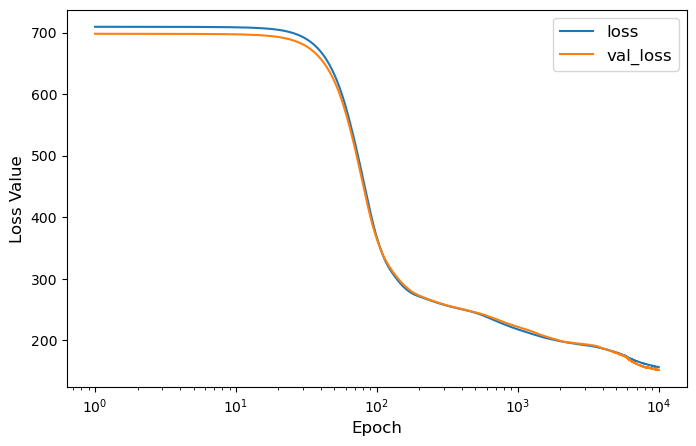

In [18]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)

Learning rate is too small; further training is required

### Evaluation on Test Data

In [19]:
# predicted bike rental rate
y_pred = ann.predict(X_test)

Text(0, 0.5, 'Predicted value')

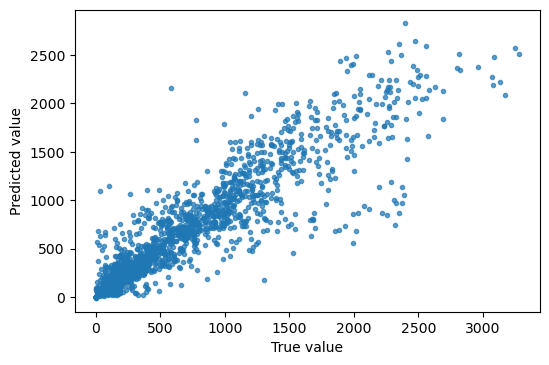

In [20]:
# plot of true rental rate against predicted value
plt.figure(figsize=(6,4),dpi=100)
plt.plot(y_test.values,y_pred,'o',markersize=3,alpha=0.7)
plt.xlabel('True value')
plt.ylabel('Predicted value')

Text(0, 0.5, 'Probability Distribution')

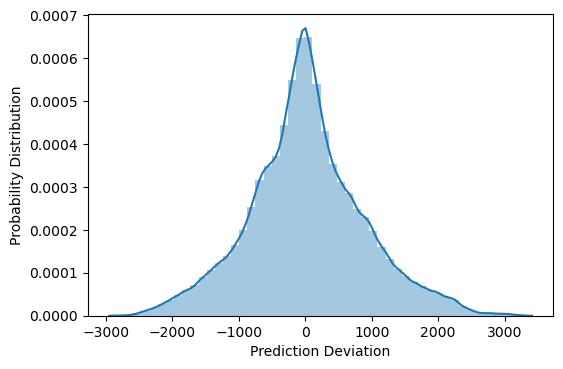

In [21]:
# distribution plot of prediction devations
plt.figure(figsize=(6,4),dpi=100)
sns.distplot(y_test.values-y_pred)
plt.xlabel('Prediction Deviation')
plt.ylabel('Probability Distribution')

Now we compute some performance metric in predicting the test values

In [22]:
from sklearn.metrics import explained_variance_score, r2_score

metric = {'value':[]}

# explained variance
exp_var = round(explained_variance_score(y_test,y_pred),3)
metric['value'].append(exp_var)

# R^2_score
r2 = round(r2_score(y_test,y_pred),3)
metric['value'].append(r2)

df_metric = pd.DataFrame(index=['explained_variance','R_squared'],
                         data=metric,
                         columns=['value'])

In [23]:
df_metric

,value
explained_variance,0.824
R_squared,0.823


Metric values are OK